# Imports

In [1]:
import os
import sys
import pysam
import pickle
import random
import modisco
import warnings
import plotnine
import pybedtools
import numpy as np
import tabix as tb
import pandas as pd
from plotnine import *
from pandas import Series
from decimal import Decimal
from kerasAC.splits import *
from matplotlib import pyplot as plt
from deeplift.dinuc_shuffle import dinuc_shuffle

from dragonn.interpret import * 
from dragonn.vis import *
from dragonn.utils import *

sys.path.insert(0, "/users/soumyak/alzheimers_parkinsons/clusters_gkmsvm")
from viz_preprocess import *
from viz_sequence import *

np.random.seed(1234)
plt.style.use('default')
pd.set_option('display.max_columns', None)

TF-MoDISco is using the TensorFlow backend.
Using TensorFlow backend.


# Quick Links

<ol>
    <li><a href=#effect_table>Effect Alleles Table</a></li>
    <li><a href=#effect_viz>Effect Alleles Visual</a></li>
    <li><a href=#noneffect_table>Non-Effect Alleles Table</a></li>
    <li><a href=#noneffect_viz>Non-Effect Alleles Visual</a></li>
</ol>

# Cluster 8

In [2]:
cluster = '8'

## Prepare Effect and Non-Effect Scores

In [3]:
effect_fasta = '/mnt/lab_data3/soumyak/adpd/fasta_inputs/Cluster'+cluster+'.effect.fasta'
effect_seqs = [x.rstrip() for (i,x) in enumerate(open(effect_fasta)) if i%2==1]
effect_onehot = [np.array(one_hot_encode_along_channel_axis(x)) for x in effect_seqs]

print("Num effect sequences:", len(effect_onehot))

merged_effect_scores = np.zeros(shape=(len(effect_onehot), 1000, 4))

for fold in range(10):
    effect_file = '/mnt/lab_data3/soumyak/adpd/explain_scores/Cluster'+cluster+'/fold'+str(fold)+'.effect.scores.txt'
    effect_scores = get_hyp_scores(effect_file, effect_seqs)
    effect_scores = np.array(effect_scores)
    merged_effect_scores = merged_effect_scores + effect_scores
    
merged_effect_scores = merged_effect_scores / (fold + 1)

#--------------------------------------------------------#

noneffect_fasta = '/mnt/lab_data3/soumyak/adpd/fasta_inputs/Cluster'+cluster+'.noneffect.fasta'
noneffect_seqs = [x.rstrip() for (i,x) in enumerate(open(noneffect_fasta)) if i%2==1]
noneffect_onehot = [np.array(one_hot_encode_along_channel_axis(x)) for x in noneffect_seqs]

print("Num noneffect sequences:", len(noneffect_onehot))

merged_noneffect_scores = np.zeros(shape=(len(noneffect_onehot), 1000, 4))

for fold in range(10):
    noneffect_file = '/mnt/lab_data3/soumyak/adpd/explain_scores/Cluster'+cluster+'/fold'+str(fold)+'.noneffect.scores.txt'
    noneffect_scores = get_hyp_scores(noneffect_file, noneffect_seqs)
    noneffect_scores = np.array(noneffect_scores)
    merged_noneffect_scores = merged_noneffect_scores + noneffect_scores
    
merged_noneffect_scores = merged_noneffect_scores / (fold + 1)

#--------------------------------------------------------#

merged_ism_scores = np.zeros(shape=(len(effect_onehot),))
merged_delta_scores = np.zeros(shape=(len(effect_onehot),))

for fold in range(10):
    ism_scores = np.array([float(i.strip().split('\t')[1]) for i in open('/mnt/lab_data3/soumyak/adpd/ism_scores/Cluster'+cluster+'/fold'+str(fold)+'.ism.scores').readlines()])
    delta_scores = np.array([float(i.strip().split('\t')[1]) for i in open('/mnt/lab_data3/soumyak/adpd/delta_scores/Cluster'+cluster+'/fold'+str(fold)+'.delta.scores').readlines()])
    merged_ism_scores = merged_ism_scores + ism_scores
    merged_delta_scores = merged_delta_scores + delta_scores
        
merged_ism_scores = merged_ism_scores / (fold + 1)
merged_delta_scores = merged_delta_scores / (fold + 1)

Num effect sequences: 202
Num noneffect sequences: 202


## Prepare DataFrame

In [4]:
snps = pd.read_csv('/mnt/lab_data3/soumyak/adpd/snp_lists/Cluster'+cluster+'.overlap.expanded.snps.hg38.bed', sep='\t')
ryan_snps = pd.read_csv('/oak/stanford/groups/akundaje/projects/alzheimers_parkinsons/snps_final/191023_All_GWAS_SNPs_unique.csv', sep='\t')
mike_snps = pd.read_csv('/oak/stanford/groups/akundaje/projects/alzheimers_parkinsons/snps_final/ld_buddies_table_stage3.tsv', sep='\t')
effect_score = []
noneffect_score = []
effect_center = []
noneffect_center = []
effect_ratio = []
noneffect_ratio = []
allele_ratio = []
allele_diff = []
effect_rank = []
noneffect_rank = []
ism_score = []
delta_score = []
idr_peak = []
all_gwas = []
coloc = []
for index,row in snps.iterrows():
    effect_score.append(np.sum(np.array([np.sum(j) for j in merged_effect_scores[index][400:600]])))
    noneffect_score.append(np.sum(np.array([np.sum(j) for j in merged_noneffect_scores[index][400:600]])))
    effect_center.append(np.sum(np.array([max(0, np.sum(j)) for j in merged_effect_scores[index][475:525]])))
    noneffect_center.append(np.sum(np.array([max(0, np.sum(j)) for j in merged_noneffect_scores[index][475:525]])))
    effect_ratio.append(np.sum(np.array([max(0, np.sum(j)) for j in merged_effect_scores[index][475:525]])) / np.sum(np.array([max(0, np.sum(j)) for j in merged_effect_scores[index][400:600]])))
    noneffect_ratio.append(np.sum(np.array([max(0, np.sum(j)) for j in merged_noneffect_scores[index][475:525]])) / np.sum(np.array([max(0, np.sum(j)) for j in merged_noneffect_scores[index][400:600]])))
    allele_ratio.append(effect_center[-1] / (noneffect_center[-1] + 0.00001))
    #allele_diff.append(effect_center[-1] - noneffect_center[-1])
    allele_diff.append(np.sum(np.array([np.sum(j) for j in merged_effect_scores[index][475:525]])) - np.sum(np.array([np.sum(j) for j in merged_noneffect_scores[index][475:525]])))
    effect_rank.append((effect_center[-1] / (noneffect_center[-1] + 0.00001)) * effect_ratio[-1])
    noneffect_rank.append((noneffect_center[-1] / (effect_center[-1] + 0.00001)) * noneffect_ratio[-1])
    idr_peak_overlap = False
    for ind,rw in ryan_snps.loc[ryan_snps['rsid']==row['rsid']].iterrows():
        if rw['Cluster'+cluster+'_overlap'] == 1:
            idr_peak_overlap = True
    idr_peak.append(idr_peak_overlap)
    gwas_list = []
    has_coloc = False
    for ind,rw in mike_snps.loc[mike_snps['rsid']==row['rsid']].iterrows():
        gwas_list.append(rw['source_gwas']+': '+str('%.2E' % Decimal(rw['pvalue'])))
        if rw['has_coloc'] == True:
            has_coloc = True
    all_gwas.append(gwas_list)
    coloc.append(has_coloc)
snps['effect_score'] = effect_score
snps['noneffect_score'] = noneffect_score
snps['effect_center'] = effect_center
snps['noneffect_center'] = noneffect_center
snps['effect_ratio'] = effect_ratio
snps['noneffect_ratio'] = noneffect_ratio
snps['allele_ratio'] = allele_ratio
snps['allele_diff'] = allele_diff
snps['effect_rank'] = effect_rank
snps['noneffect_rank'] = noneffect_rank
snps['ism_score'] = merged_ism_scores
snps['delta_score'] = merged_delta_scores
snps['idr_peak'] = idr_peak
snps['all_gwas'] = all_gwas
snps['coloc'] = coloc
snps.sort_values(by=['allele_ratio'], ascending=True, inplace=True)
snps.drop_duplicates(subset=['rsid'], inplace=True)

## Find Effect Alleles that Break Accessibility <a name='effect_table' />

In [5]:
neg_snps = snps.loc[snps['allele_ratio'] <= 1]
neg_snps.sort_values(by=['noneffect_rank'], ascending=False, inplace=True)
display(neg_snps)

chr      start        end         rsid effect noneffect ref  alt major  \
148   chr2  127128581  127128582   rs13025717      T         C   C    T     C   
175   chr4   17938116   17938117    rs6845118      T         G   G  A,T     G   
62   chr17   45894775   45894776   rs11575896      G         A   G    A     G   
102  chr19   44644418   44644419   rs10426401      T         G   T    G     T   
160   chr3   49007333   49007334    rs6781790      T         C   C    T     T   
143   chr2  127107344  127107345   rs76516995    NAN       NAN   C  A,G     C   
184   chr4   89837895   89837896    rs2619363    NAN       NAN   G  C,T     G   
167   chr3   52771464   52771465  rs147131488      T         G   G  A,T     G   
78   chr17   46132107   46132108  rs112401617      T         A   A    T     A   
107  chr19   44890258   44890259  rs117310449      T         C   C    T     C   
191   chr6   27772520   27772521     rs760587      C         A   C    A     C   
145   chr2  127107345  127107346   rs78710909    NAN       NAN   G    C     G   
190   chr6   27754284   27754285    rs4713121      T         C   T    C     T   
43   chr17   45639518   45639519     rs413778      A         G   A    G     A   
194   chr7  100428668  100428669    rs3807475      A         G   G    A     G   
18   chr11  121590136  121590137    rs2276412      T         C   C  G,T     C   
28   chr16   30922753   30922754    rs3813020      G         A   G    A     A   
60   chr17   45894418   45894419   rs11575895      G         A   A    G     A   
119  chr19   44951508   44951509    rs7247551      A         G   G    A     A   
158   chr3   48740593   48740594    rs6442130      G         A   A    G     G   
100  chr19   44644039   44644040   rs11540084      T         G   G    T     G   
95   chr18   51197068   51197069    rs4396619      T         C   C    T     C   
138   chr2   95076932   95076933    rs3105101      C         A   C    A     A   
72   chr17   45949181   45949182     rs242561      T         C   T    C     C   
199   chr8   27608663   27608664    rs1532277      T         C   T    C     C   
188   chr5  103120549  103120550      rs26523      T         C   C    T     C   
7    chr10   15515276   15515277     rs896434      T         G   T    G     G   
165   chr3   52339803   52339804  rs186007490      T         C   C  G,T     C   
88   chr17   75033998   75033999   rs12943281      A         G   G    A     G   
90   chr17   75035094   75035095    rs7210163      A         G   G    A     G   
..     ...        ...        ...          ...    ...       ...  ..  ...   ...   
192   chr7   23106492   23106493    rs2072368      T         C   C    T     C   
73   chr17   46057543   46057544   rs62060767      G         A   G    A     G   
135  chr19   45187630   45187631   rs12460985      T         C   T    C     T   
27   chr15   78944950   78944951    rs2289702      T         C   C    T     C   
170   chr4     973550     973551  rs113075206      G         C   C    G     C   
159   chr3   48998451   48998452    rs6414613      T         C   C    T     T   
63   chr17   45895713   45895714   rs74548327      G         A   A    G     A   
152   chr2  134719264  134719265   rs62171395      G         C   C    G     C   
56   chr17   45849625   45849626   rs56269136      T         C   C    T     C   
26   chr15   63277702   63277703  rs117618017      T         C   C    T     C   
53   chr17   45826118   45826119   rs62057148      G         C   G  A,C     G   
180   chr4   89836157   89836158    rs1372519      A         G   A    G     G   
173   chr4     987107     987108   rs11248061      C         A   C    A     C   
59   chr17   45894237   45894238   rs62056778      G         C   C    G     C   
189   chr5  103120599  103120600      rs26524      G         A   A    G     A   
66   chr17   45913295   45913296    rs9944484      G         A   G    A     G   
121  chr19   44954888   44954889    rs3760629      C         A   A    C     C   
162   chr3   49059414   49059415    rs

## Visualize Top Effect Alleles <a name='effect_viz' />

RSID: rs13025717   ||    chr2 : 127128581 - 127128582   ||    Locus: 148   ||    IDR Peak: True

GWAS:
Alzheimers_Jansen_2018 		  9.13E-17
Alzheimers_Kunkle_2019 		  2.98E-15
Alzheimers_Lambert_2013 	  7.94E-13

Coloc:  False

Noneffect Allele : C   ||   Explain Score : 0.8868   ||   Center / 200bp : 0.4759
Noneffect Sequence : CAGAAGCCCCGCCCAATGAG


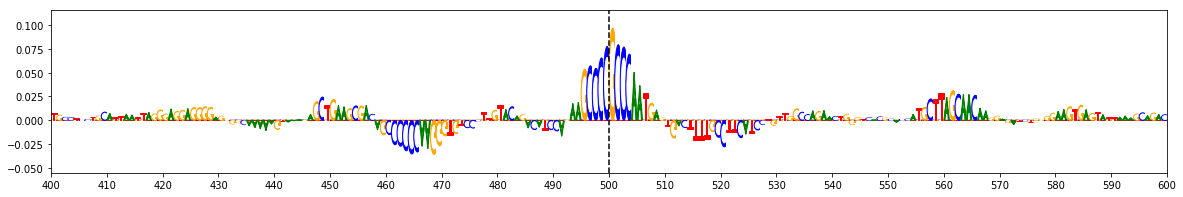

Effect Allele : T   ||   Explain Score : 0.1787   ||   Center / 200bp : 0.1548
Effect Sequence : CAGAAGCCCTGCCCAATGAG


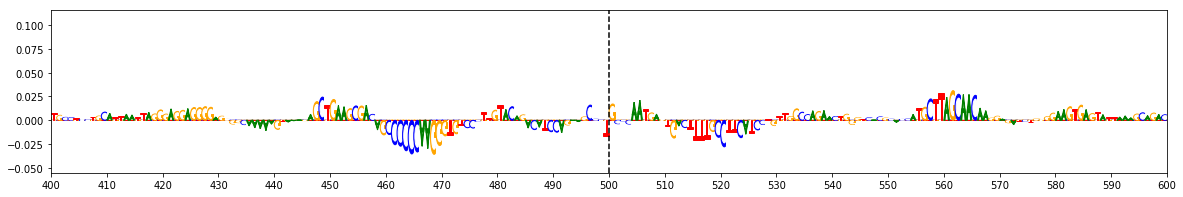

Allele Ratio : 0.2016   ||   Allele Difference : -0.7394  ||  ISM Score : -1.1533  ||  deltaSVM Score : -6.5484


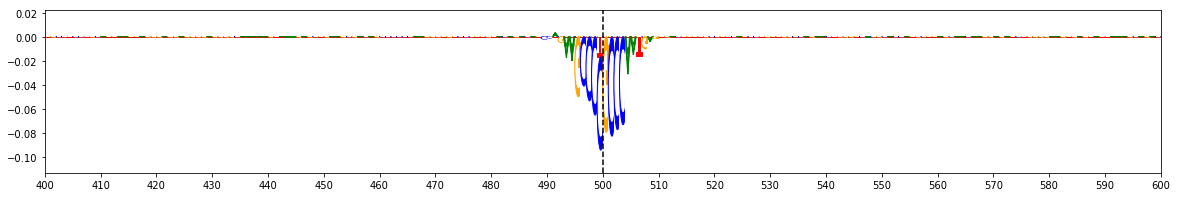


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs6845118   ||    chr4 : 17938116 - 17938117   ||    Locus: 175   ||    IDR Peak: False

GWAS:
Nalls_23andMe 		  1.39E-02

Coloc:  False

Noneffect Allele : G   ||   Explain Score : 0.2396   ||   Center / 200bp : 0.5349
Noneffect Sequence : CAATTCTCCGGCCTCAGCCT


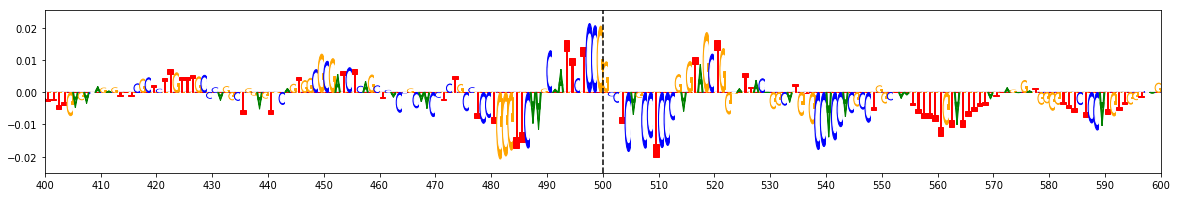

Effect Allele : T   ||   Explain Score : 0.1146   ||   Center / 200bp : 0.3554
Effect Sequence : CAATTCTCCTGCCTCAGCCT


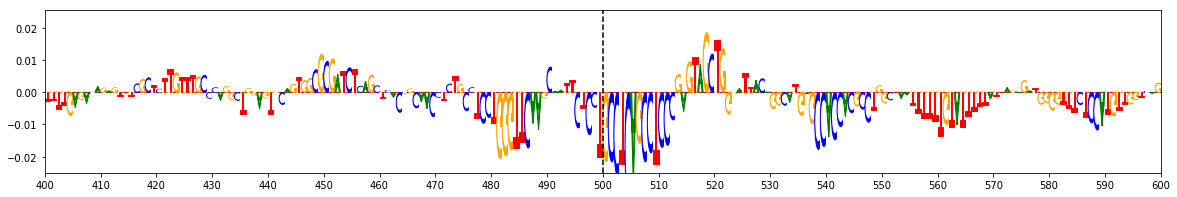

Allele Ratio : 0.4782   ||   Allele Difference : -0.3204  ||  ISM Score : -0.5344  ||  deltaSVM Score : -3.0706


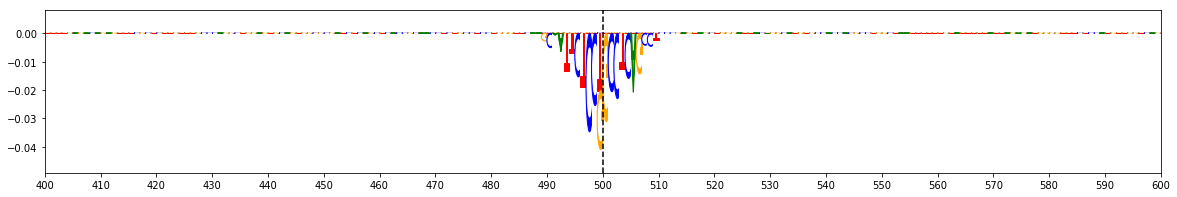


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs11575896   ||    chr17 : 45894775 - 45894776   ||    Locus: 62   ||    IDR Peak: True

GWAS:
23andme_PD_hg38 		  3.94E-22

Coloc:  True

Noneffect Allele : A   ||   Explain Score : 0.9428   ||   Center / 200bp : 0.7373
Noneffect Sequence : GCAGACTGGAGCTTCGTGCG


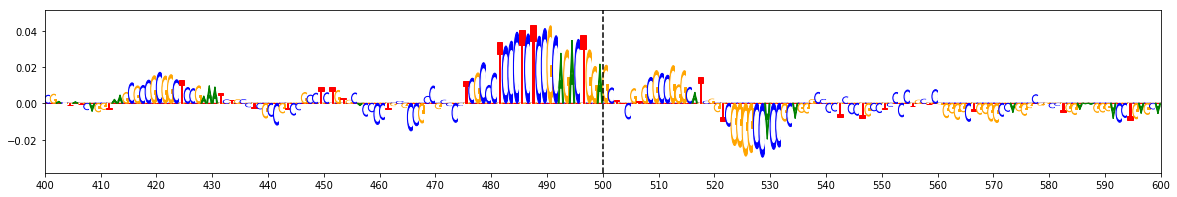

Effect Allele : G   ||   Explain Score : 0.7598   ||   Center / 200bp : 0.6936
Effect Sequence : GCAGACTGGGGCTTCGTGCG


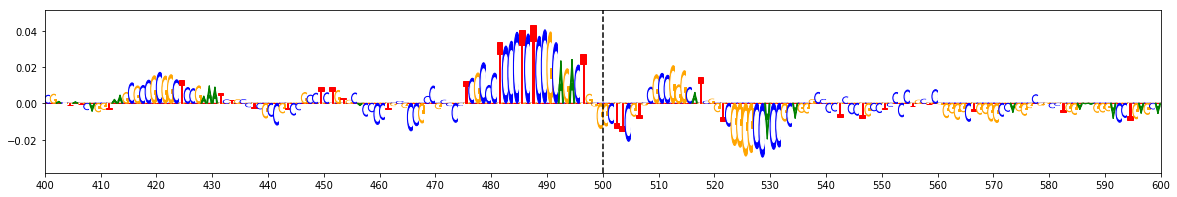

Allele Ratio : 0.8058   ||   Allele Difference : -0.2797  ||  ISM Score : -0.4492  ||  deltaSVM Score : -2.5902


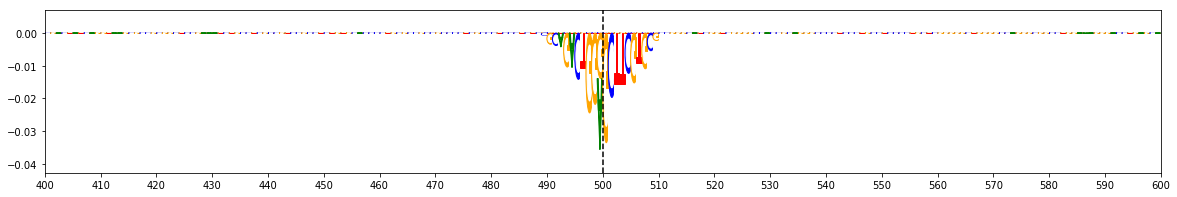


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs10426401   ||    chr19 : 44644418 - 44644419   ||    Locus: 102   ||    IDR Peak: True

GWAS:
Alzheimers_Jansen_2018 		  4.63E-14
Alzheimers_Kunkle_2019 		  5.66E-11
Alzheimers_Lambert_2013 	  2.79E-09

Coloc:  True

Noneffect Allele : G   ||   Explain Score : 0.6781   ||   Center / 200bp : 0.3961
Noneffect Sequence : CAACACGGGGCGGGCACAAG


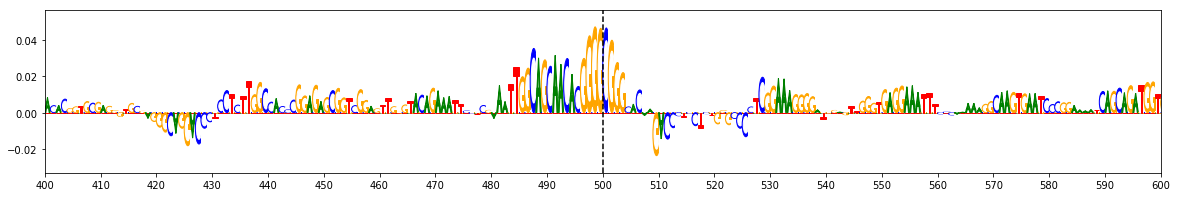

Effect Allele : T   ||   Explain Score : 0.2965   ||   Center / 200bp : 0.2225
Effect Sequence : CAACACGGGTCGGGCACAAG


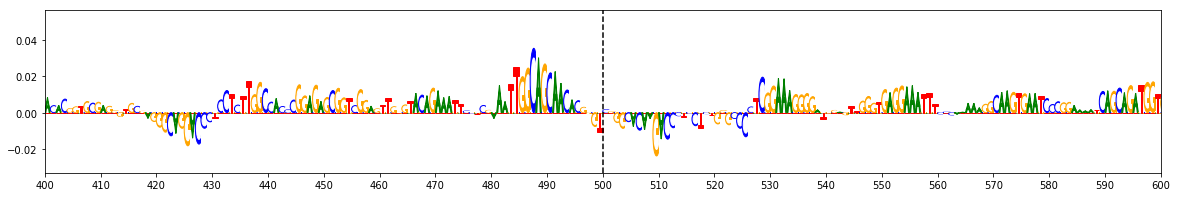

Allele Ratio : 0.4373   ||   Allele Difference : -0.4478  ||  ISM Score : -0.7148  ||  deltaSVM Score : -4.1006


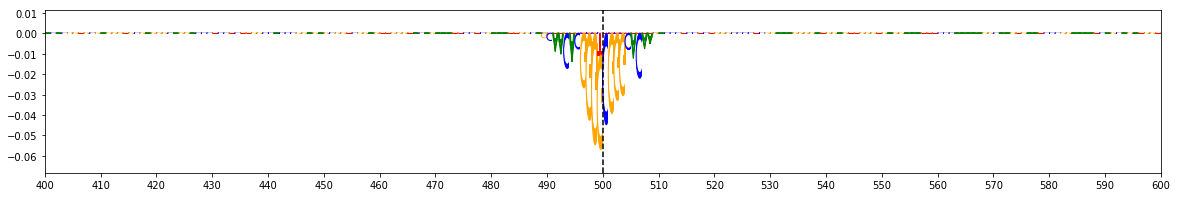


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs6781790   ||    chr3 : 49007333 - 49007334   ||    Locus: 160   ||    IDR Peak: True

GWAS:
Chang_23andMe_Parkinsons 	  2.35E-03
Nalls_23andMe 		  2.35E-03

Coloc:  False

Noneffect Allele : C   ||   Explain Score : 0.9864   ||   Center / 200bp : 0.3881
Noneffect Sequence : AGCTGAGGGCGCTGTTGATG


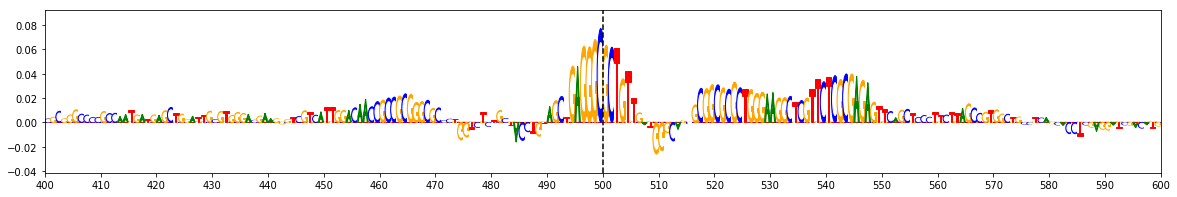

Effect Allele : T   ||   Explain Score : 0.4291   ||   Center / 200bp : 0.216
Effect Sequence : AGCTGAGGGTGCTGTTGATG


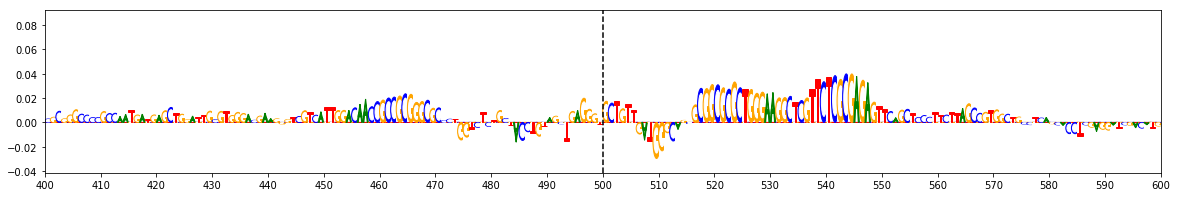

Allele Ratio : 0.435   ||   Allele Difference : -0.6147  ||  ISM Score : -0.968  ||  deltaSVM Score : -5.6311


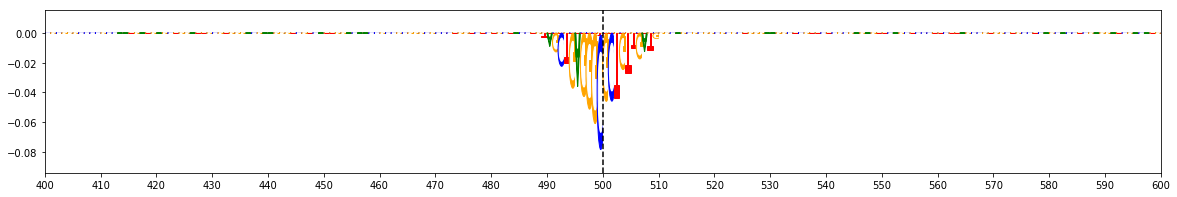


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs76516995   ||    chr2 : 127107344 - 127107345   ||    Locus: 143   ||    IDR Peak: True

GWAS:
Alzheimers_Lambert_2013 	  NAN
Alzheimers_Kunkle_2019 		  4.83E-10

Coloc:  False

Noneffect Allele : NAN   ||   Explain Score : 1.7899   ||   Center / 200bp : 0.6794
Noneffect Sequence : GCACCGCCCCGGGGCGGGGA


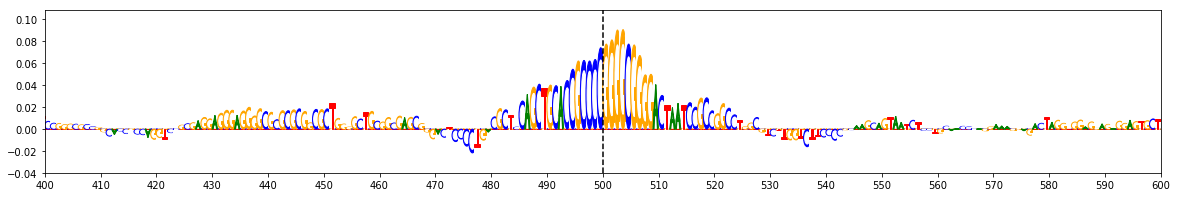

Effect Allele : NAN   ||   Explain Score : 1.4207   ||   Center / 200bp : 0.62
Effect Sequence : GCACCGCCCAGGGGCGGGGA


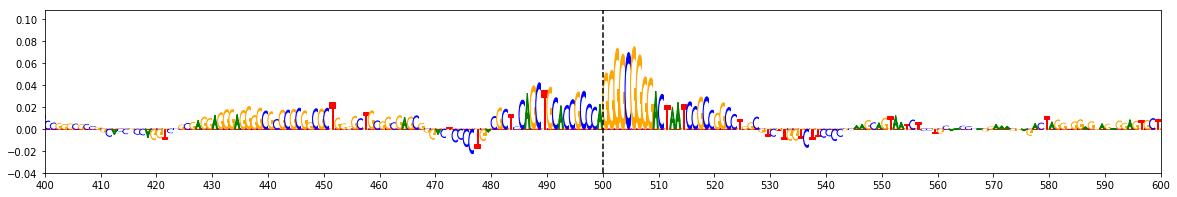

Allele Ratio : 0.7938   ||   Allele Difference : -0.3712  ||  ISM Score : -0.4744  ||  deltaSVM Score : -3.898


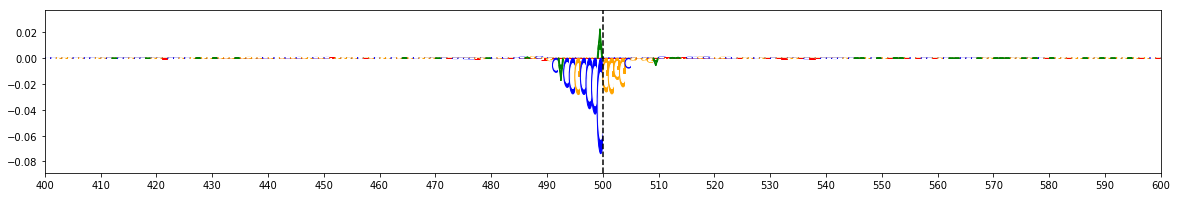


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs2619363   ||    chr4 : 89837895 - 89837896   ||    Locus: 184   ||    IDR Peak: True

GWAS:
Parkinsons_Pankratz_2012 	  NAN
23andme_PD_hg38 		  1.43E-08

Coloc:  True

Noneffect Allele : NAN   ||   Explain Score : 1.3804   ||   Center / 200bp : 0.6162
Noneffect Sequence : CCAATCAGCGCCTGCCAGAC


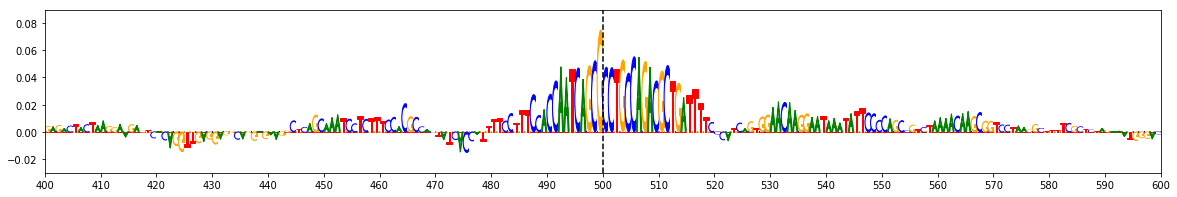

Effect Allele : NAN   ||   Explain Score : 1.0257   ||   Center / 200bp : 0.5421
Effect Sequence : CCAATCAGCCCCTGCCAGAC


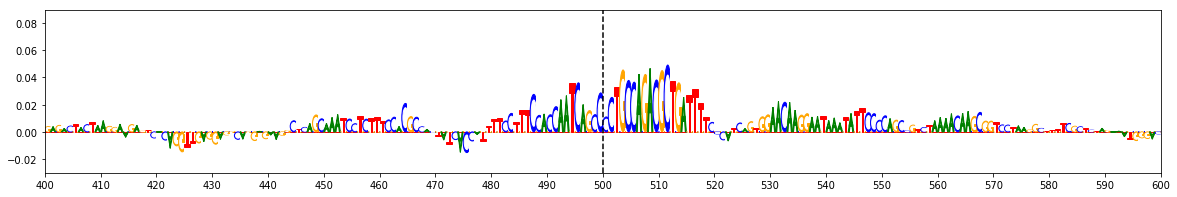

Allele Ratio : 0.7431   ||   Allele Difference : -0.355  ||  ISM Score : -0.5265  ||  deltaSVM Score : -3.3303


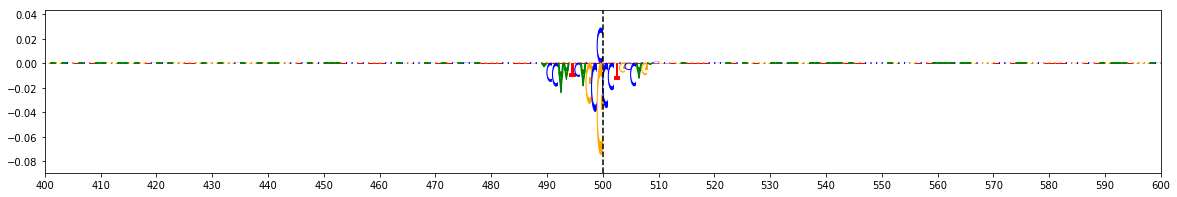


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs147131488   ||    chr3 : 52771464 - 52771465   ||    Locus: 167   ||    IDR Peak: True

GWAS:
Chang_23andMe_Parkinsons 	  2.00E-03

Coloc:  False

Noneffect Allele : G   ||   Explain Score : 0.4766   ||   Center / 200bp : 0.3005
Noneffect Sequence : GCACTAAGAGACTTGACTAA


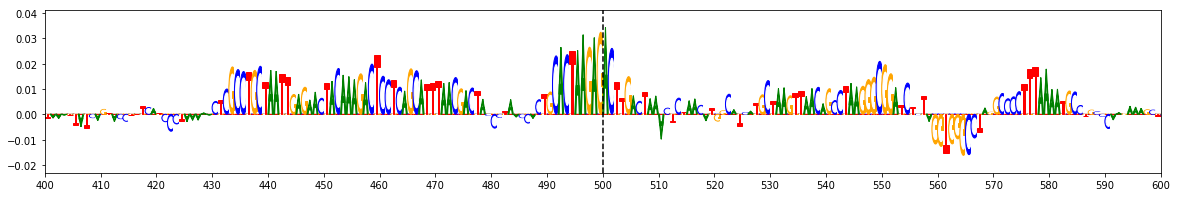

Effect Allele : T   ||   Explain Score : 0.1747   ||   Center / 200bp : 0.1361
Effect Sequence : GCACTAAGATACTTGACTAA


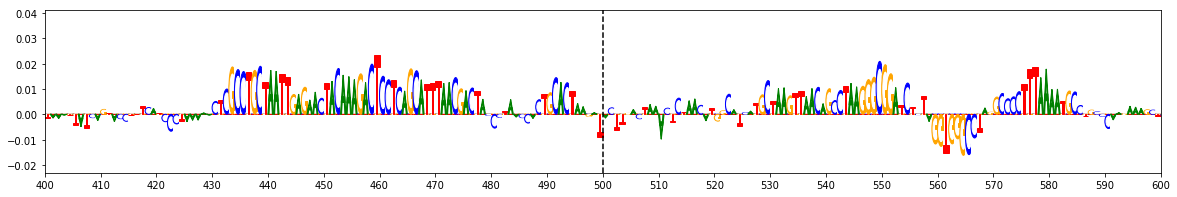

Allele Ratio : 0.3666   ||   Allele Difference : -0.3251  ||  ISM Score : -0.5136  ||  deltaSVM Score : -2.9606


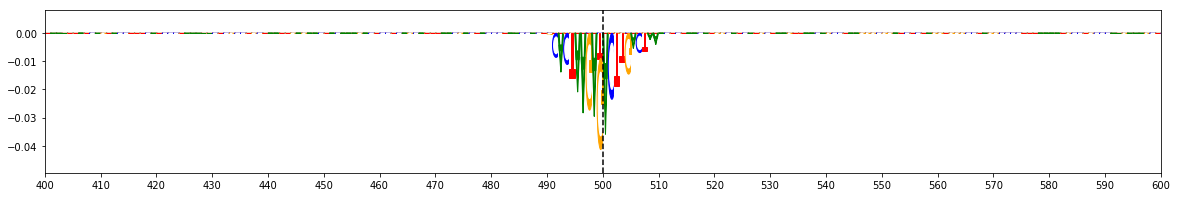


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs112401617   ||    chr17 : 46132107 - 46132108   ||    Locus: 78   ||    IDR Peak: False

GWAS:
23andme_PD_hg38 		  2.70E-22

Coloc:  True

Noneffect Allele : A   ||   Explain Score : 0.2393   ||   Center / 200bp : 0.4077
Noneffect Sequence : CCTGGGCCAAAACAGCAAAA


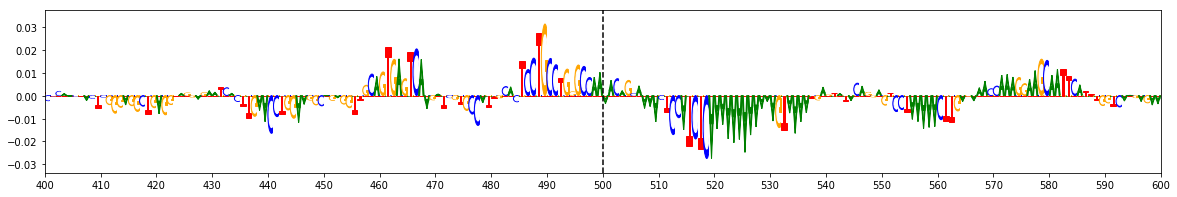

Effect Allele : T   ||   Explain Score : 0.1228   ||   Center / 200bp : 0.2607
Effect Sequence : CCTGGGCCATAACAGCAAAA


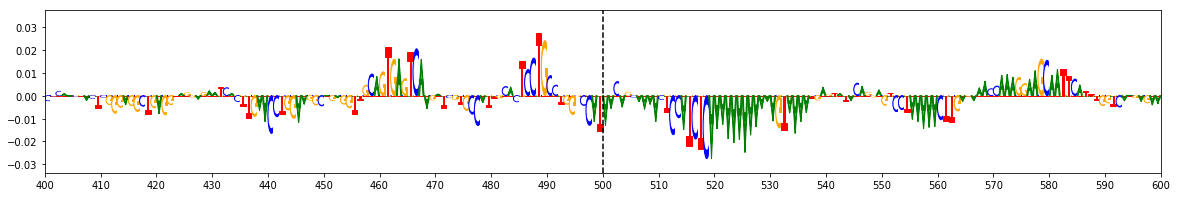

Allele Ratio : 0.513   ||   Allele Difference : -0.2  ||  ISM Score : -0.3199  ||  deltaSVM Score : -1.8681


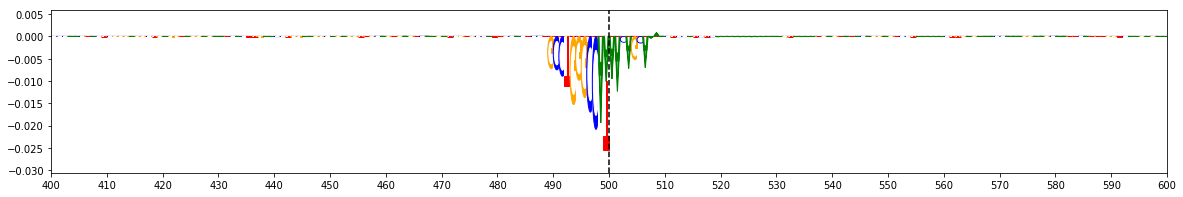


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs117310449   ||    chr19 : 44890258 - 44890259   ||    Locus: 107   ||    IDR Peak: True

GWAS:
Alzheimers_Jansen_2018 		  7.04E-94
Alzheimers_Kunkle_2019 		  2.28E-46
Alzheimers_Lambert_2013 	  3.69E-36

Coloc:  True

Noneffect Allele : C   ||   Explain Score : 0.9003   ||   Center / 200bp : 0.6143
Noneffect Sequence : GGCCAGAGGCAGAGTGATGA


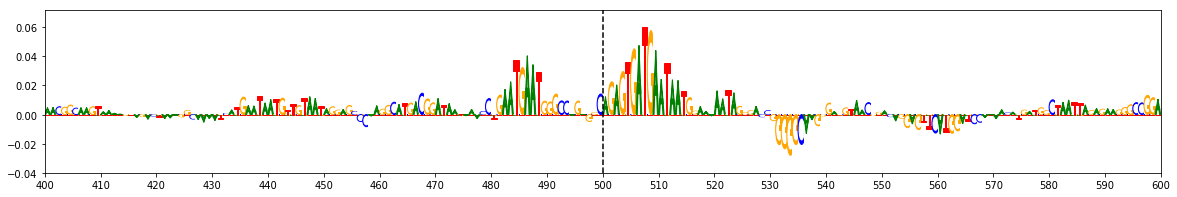

Effect Allele : T   ||   Explain Score : 0.7135   ||   Center / 200bp : 0.5576
Effect Sequence : GGCCAGAGGTAGAGTGATGA


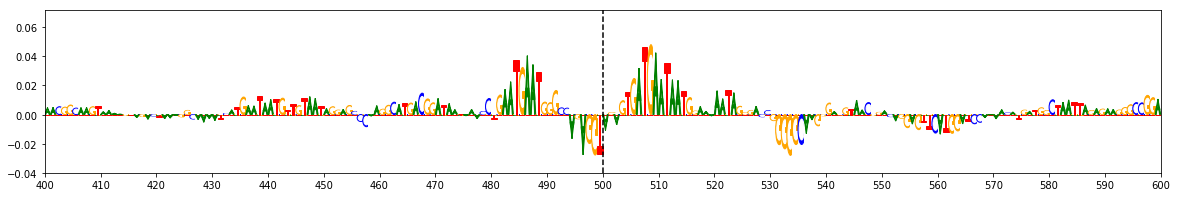

Allele Ratio : 0.7925   ||   Allele Difference : -0.3211  ||  ISM Score : -0.5112  ||  deltaSVM Score : -2.9302


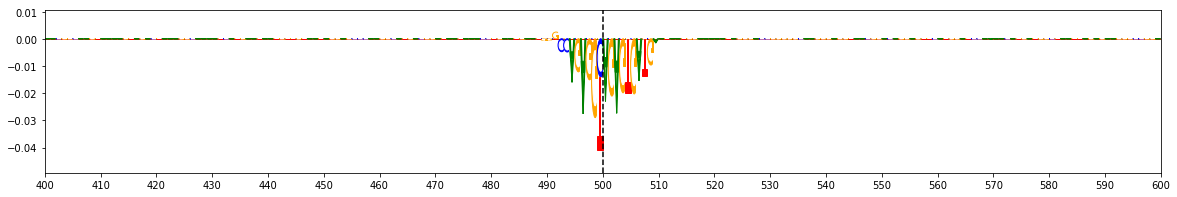


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs760587   ||    chr6 : 27772520 - 27772521   ||    Locus: 191   ||    IDR Peak: True

GWAS:
Nalls_23andMe 		  6.44E-06

Coloc:  False

Noneffect Allele : A   ||   Explain Score : 1.409   ||   Center / 200bp : 0.594
Noneffect Sequence : GAGCAGCAAACAAAGGCTAA


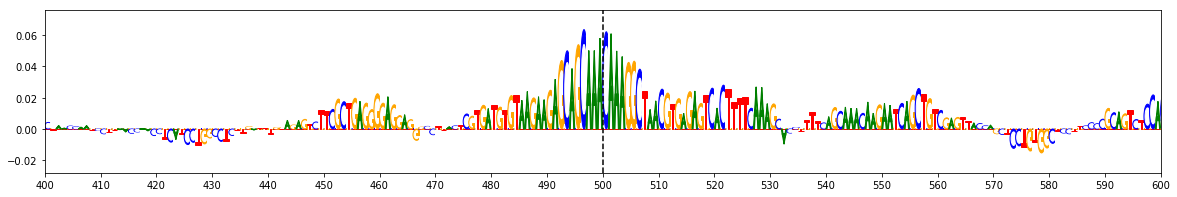

Effect Allele : C   ||   Explain Score : 1.1173   ||   Center / 200bp : 0.5361
Effect Sequence : GAGCAGCAACCAAAGGCTAA


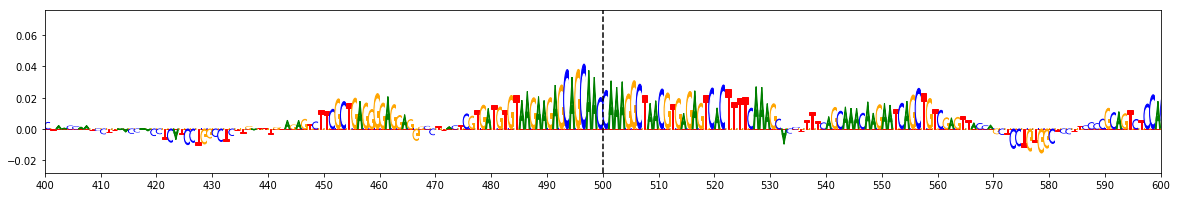

Allele Ratio : 0.793   ||   Allele Difference : -0.2917  ||  ISM Score : -0.4633  ||  deltaSVM Score : -2.6528


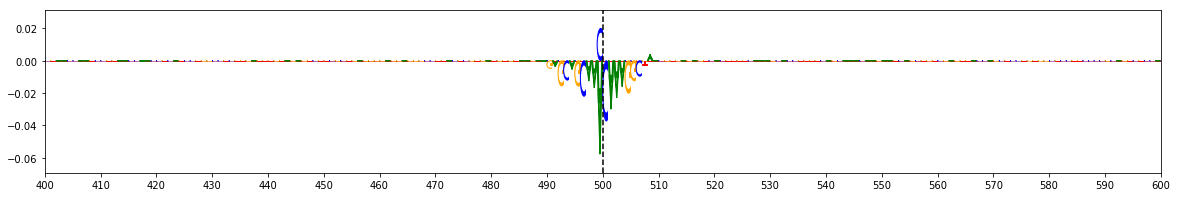


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs78710909   ||    chr2 : 127107345 - 127107346   ||    Locus: 145   ||    IDR Peak: True

GWAS:
Alzheimers_Kunkle_2019 		  4.44E-07
Alzheimers_Lambert_2013 	  NAN

Coloc:  False

Noneffect Allele : NAN   ||   Explain Score : 1.7936   ||   Center / 200bp : 0.6816
Noneffect Sequence : CACCGCCCCGGGGCGGGGAC


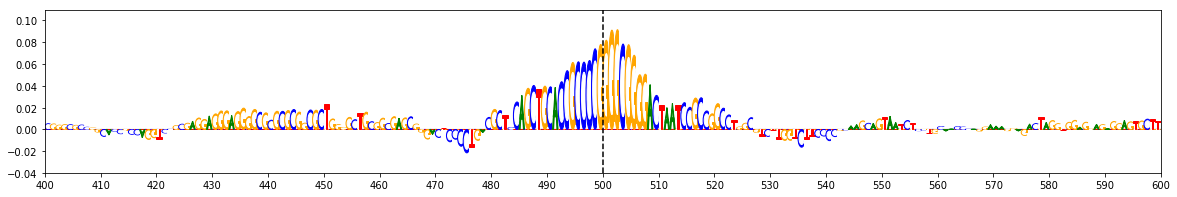

Effect Allele : NAN   ||   Explain Score : 1.6709   ||   Center / 200bp : 0.6601
Effect Sequence : CACCGCCCCCGGGCGGGGAC


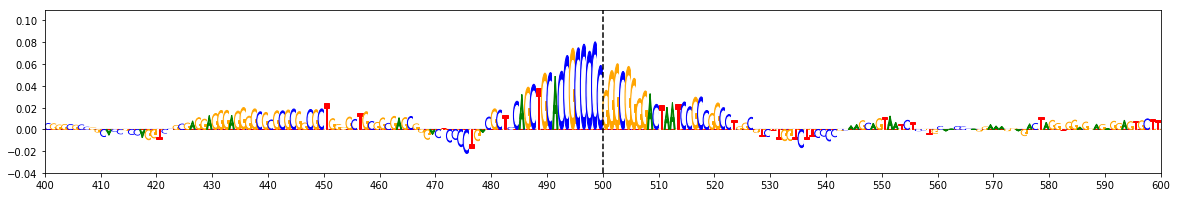

Allele Ratio : 0.9316   ||   Allele Difference : -0.1241  ||  ISM Score : -0.0868  ||  deltaSVM Score : -1.5265


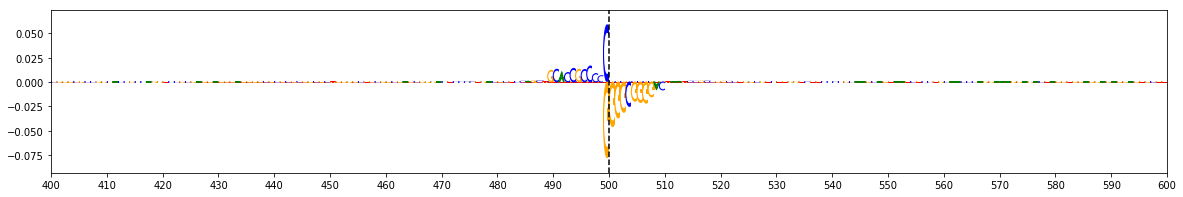


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs4713121   ||    chr6 : 27754284 - 27754285   ||    Locus: 190   ||    IDR Peak: True

GWAS:
Nalls_23andMe 		  1.30E-05

Coloc:  False

Noneffect Allele : C   ||   Explain Score : 1.2596   ||   Center / 200bp : 0.5941
Noneffect Sequence : GCAACGCCCCGAACGGTGGG


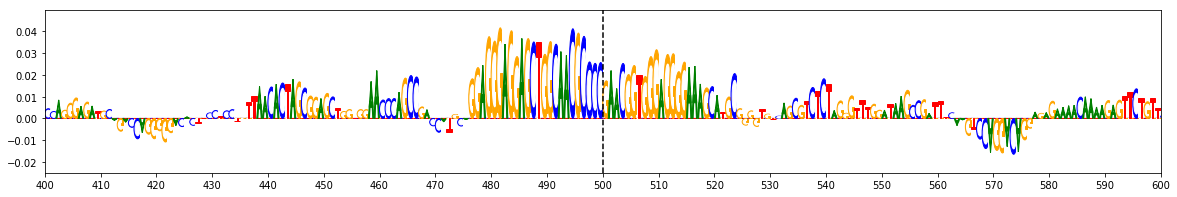

Effect Allele : T   ||   Explain Score : 1.0239   ||   Center / 200bp : 0.5434
Effect Sequence : GCAACGCCCTGAACGGTGGG


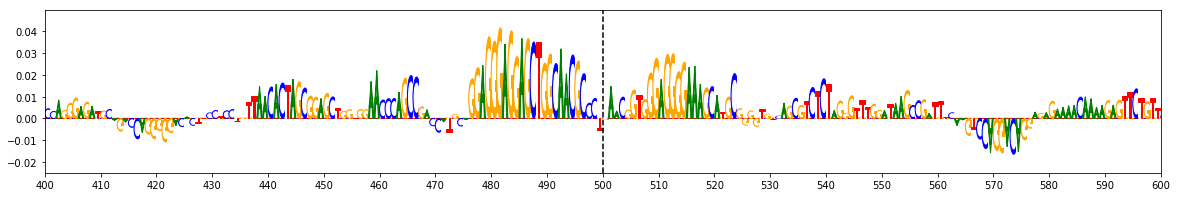

Allele Ratio : 0.8128   ||   Allele Difference : -0.2414  ||  ISM Score : -0.377  ||  deltaSVM Score : -2.1904


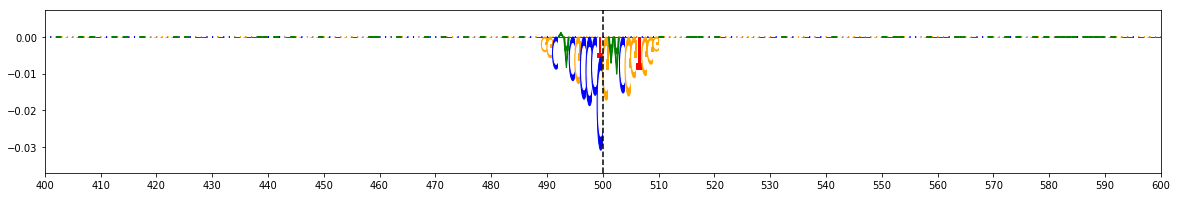


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs413778   ||    chr17 : 45639518 - 45639519   ||    Locus: 43   ||    IDR Peak: True

GWAS:
23andme_PD_hg38 		  2.96E-22
Parkinsons_Pankratz_2012 	  2.17E-10

Coloc:  True

Noneffect Allele : G   ||   Explain Score : 1.0531   ||   Center / 200bp : 0.4775
Noneffect Sequence : GGTGAGTCAGAGTAAGTATA


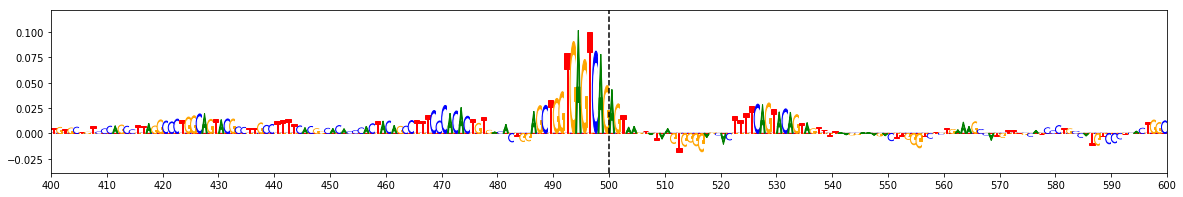

Effect Allele : A   ||   Explain Score : 0.6918   ||   Center / 200bp : 0.3751
Effect Sequence : GGTGAGTCAAAGTAAGTATA


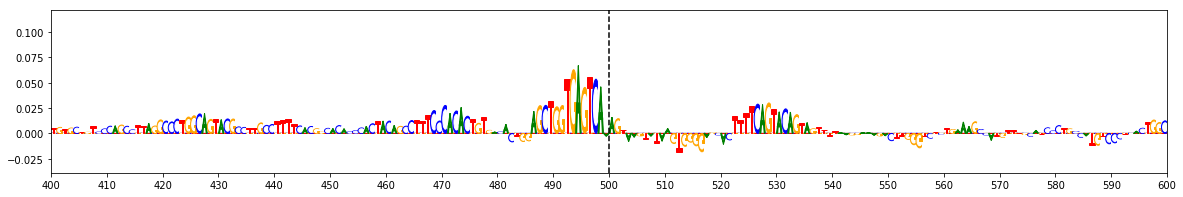

Allele Ratio : 0.657   ||   Allele Difference : -0.3905  ||  ISM Score : -0.6082  ||  deltaSVM Score : -3.5411


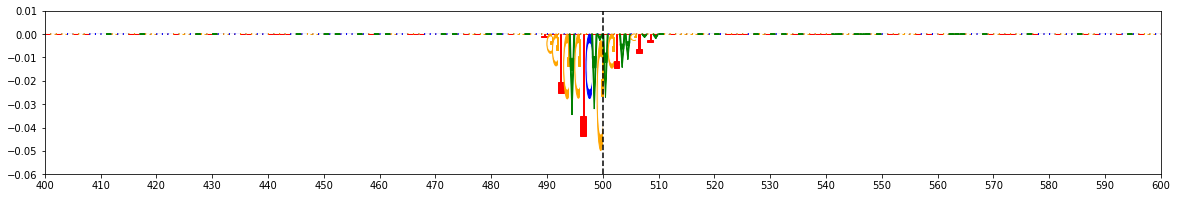


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs3807475   ||    chr7 : 100428668 - 100428669   ||    Locus: 194   ||    IDR Peak: True

GWAS:
Alzheimers_Jansen_2018 		  4.18E-07

Coloc:  True

Noneffect Allele : G   ||   Explain Score : 1.0126   ||   Center / 200bp : 0.5804
Noneffect Sequence : ATCTCCCCGGGAAAACGGCG


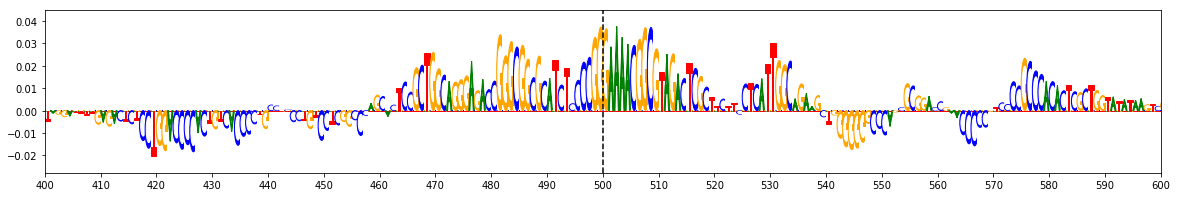

Effect Allele : A   ||   Explain Score : 0.8304   ||   Center / 200bp : 0.5309
Effect Sequence : ATCTCCCCGAGAAAACGGCG


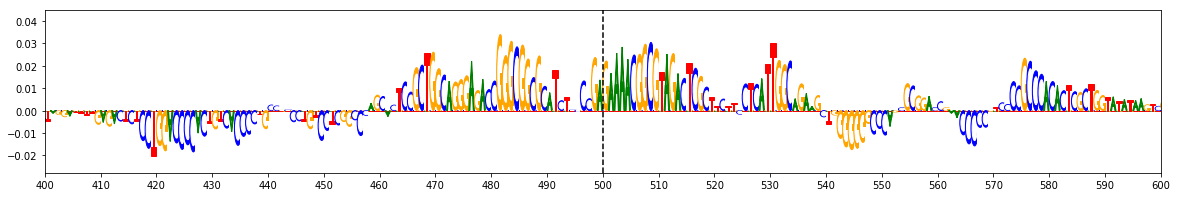

Allele Ratio : 0.8201   ||   Allele Difference : -0.1824  ||  ISM Score : -0.284  ||  deltaSVM Score : -1.6919


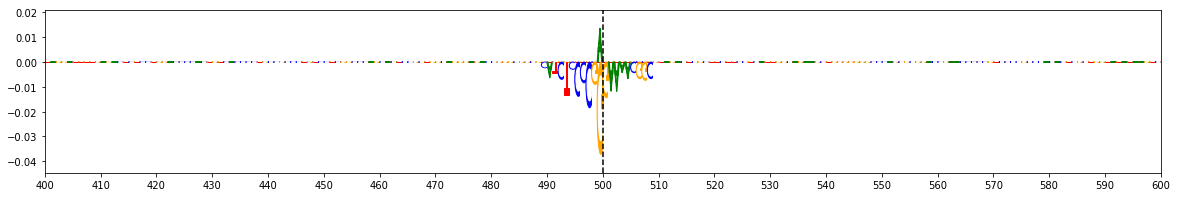


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs2276412   ||    chr11 : 121590136 - 121590137   ||    Locus: 18   ||    IDR Peak: True

GWAS:
Alzheimers_Jansen_2018 		  5.41E-08

Coloc:  False

Noneffect Allele : C   ||   Explain Score : 0.6253   ||   Center / 200bp : 0.5309
Noneffect Sequence : CAGGGAGAACGACTGTGGGG


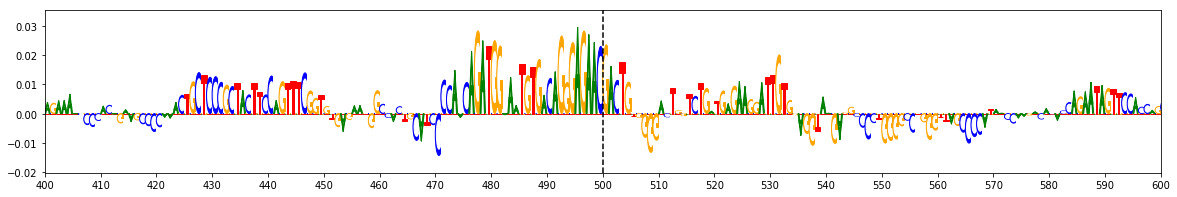

Effect Allele : T   ||   Explain Score : 0.4694   ||   Center / 200bp : 0.4594
Effect Sequence : CAGGGAGAATGACTGTGGGG


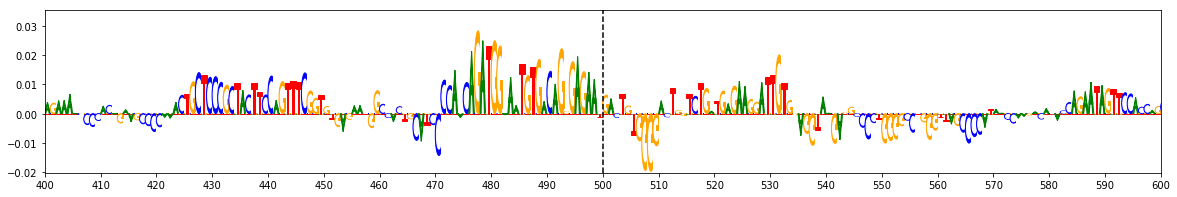

Allele Ratio : 0.7506   ||   Allele Difference : -0.1929  ||  ISM Score : -0.3018  ||  deltaSVM Score : -1.7399


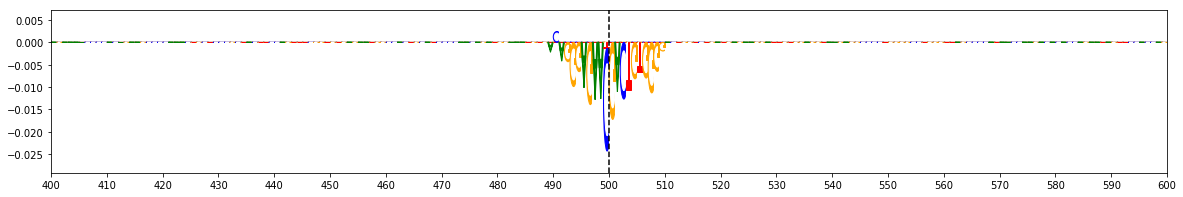


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs3813020   ||    chr16 : 30922753 - 30922754   ||    Locus: 28   ||    IDR Peak: True

GWAS:
Nalls_23andMe 		  4.32E-05

Coloc:  False

Noneffect Allele : A   ||   Explain Score : 1.2595   ||   Center / 200bp : 0.5706
Noneffect Sequence : TTTGCCGGTAGCCCCGCCCC


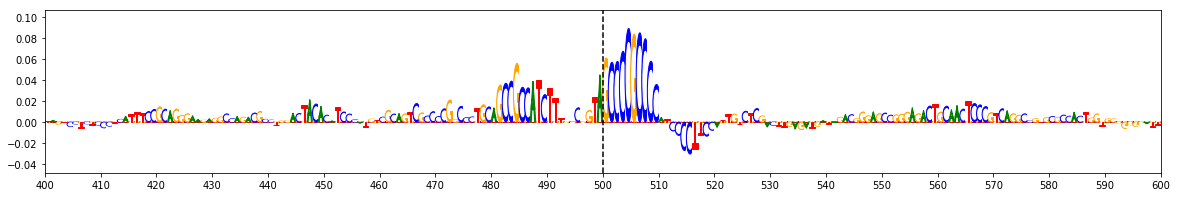

Effect Allele : G   ||   Explain Score : 1.0185   ||   Center / 200bp : 0.5181
Effect Sequence : TTTGCCGGTGGCCCCGCCCC


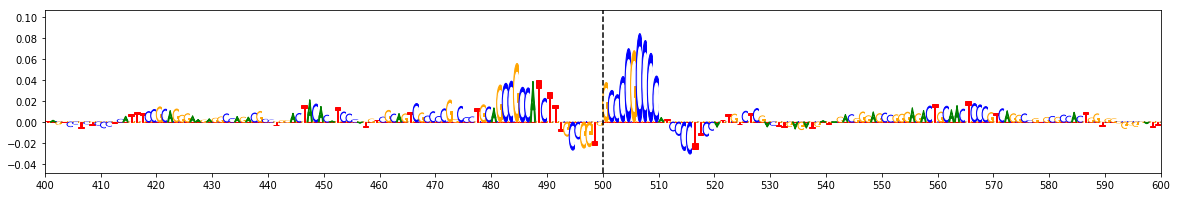

Allele Ratio : 0.8086   ||   Allele Difference : -0.3784  ||  ISM Score : -0.5951  ||  deltaSVM Score : -3.3823


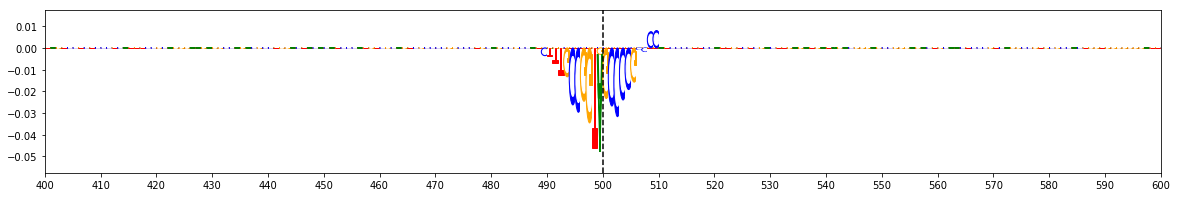


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs11575895   ||    chr17 : 45894418 - 45894419   ||    Locus: 60   ||    IDR Peak: True

GWAS:
23andme_PD_hg38 		  3.94E-22

Coloc:  True

Noneffect Allele : A   ||   Explain Score : 2.3849   ||   Center / 200bp : 0.6501
Noneffect Sequence : GCGCCCACTAGTGGCCGGAG


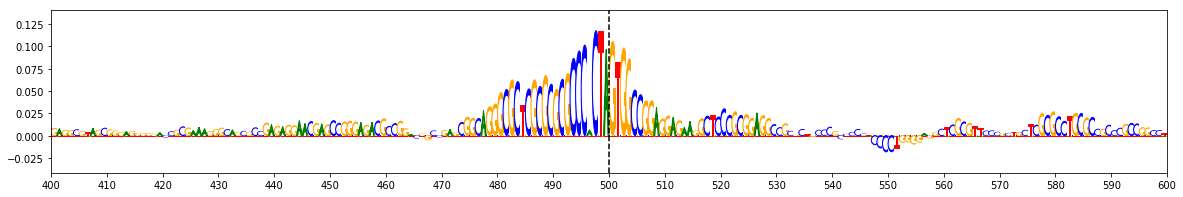

Effect Allele : G   ||   Explain Score : 2.2269   ||   Center / 200bp : 0.6322
Effect Sequence : GCGCCCACTGGTGGCCGGAG


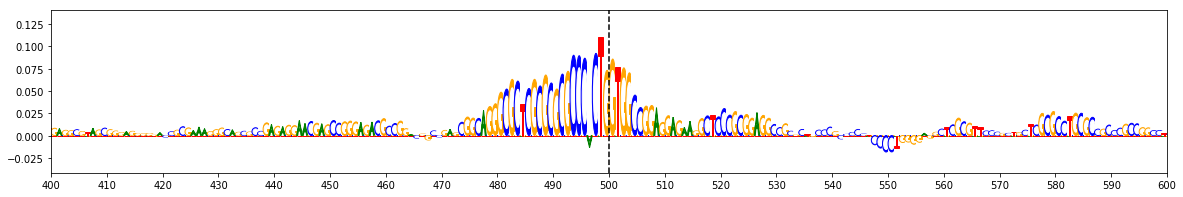

Allele Ratio : 0.9338   ||   Allele Difference : -0.1714  ||  ISM Score : -0.2275  ||  deltaSVM Score : -1.8094


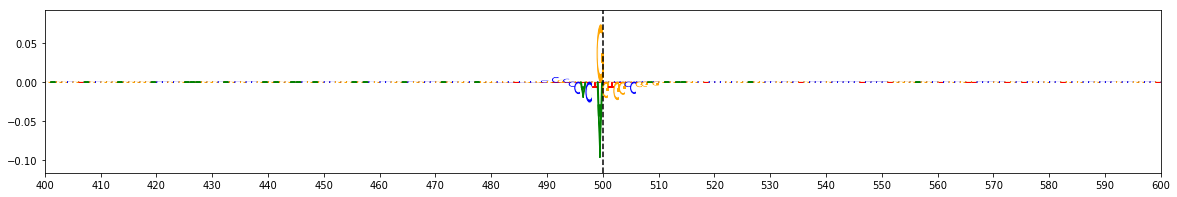


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs7247551   ||    chr19 : 44951508 - 44951509   ||    Locus: 119   ||    IDR Peak: True

GWAS:
Alzheimers_Jansen_2018 		  1.01E-04
Alzheimers_Kunkle_2019 		  9.50E-10
Alzheimers_Lambert_2013 	  3.38E-10

Coloc:  True

Noneffect Allele : G   ||   Explain Score : 1.0767   ||   Center / 200bp : 0.5191
Noneffect Sequence : TCAAGCCAAGCCAAAGCACT


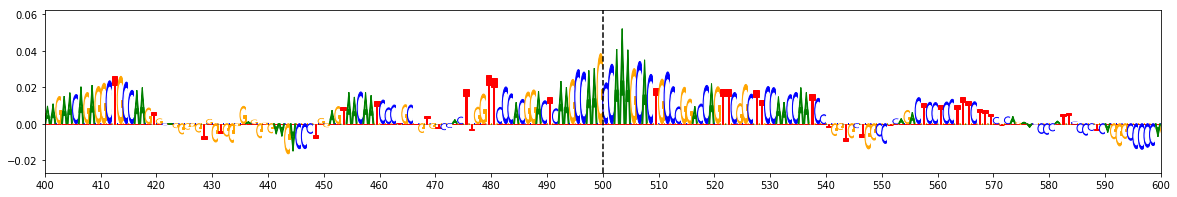

Effect Allele : A   ||   Explain Score : 0.8196   ||   Center / 200bp : 0.451
Effect Sequence : TCAAGCCAAACCAAAGCACT


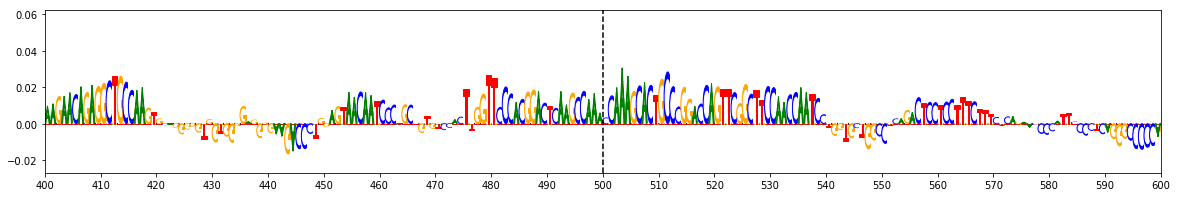

Allele Ratio : 0.7612   ||   Allele Difference : -0.2571  ||  ISM Score : -0.4001  ||  deltaSVM Score : -2.3309


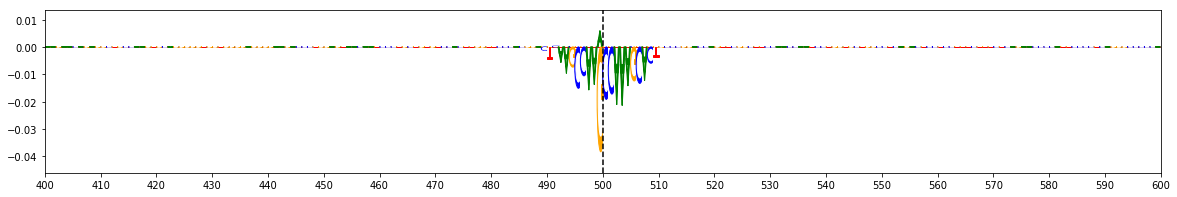


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs6442130   ||    chr3 : 48740593 - 48740594   ||    Locus: 158   ||    IDR Peak: True

GWAS:
Chang_23andMe_Parkinsons 	  1.00E-03
Nalls_23andMe 		  1.00E-03

Coloc:  False

Noneffect Allele : A   ||   Explain Score : 1.2051   ||   Center / 200bp : 0.569
Noneffect Sequence : TGTTTCAGCAGCCTTCCCCA


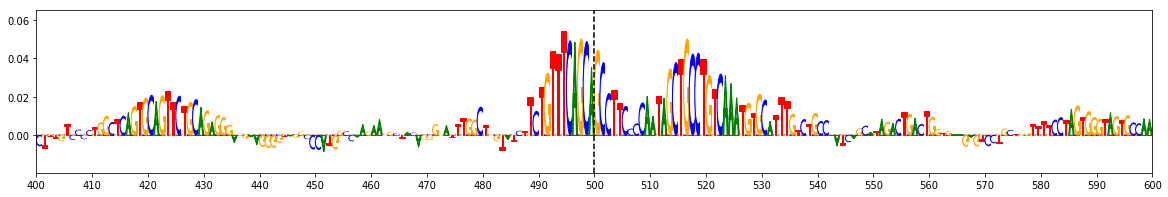

Effect Allele : G   ||   Explain Score : 1.03   ||   Center / 200bp : 0.5301
Effect Sequence : TGTTTCAGCGGCCTTCCCCA


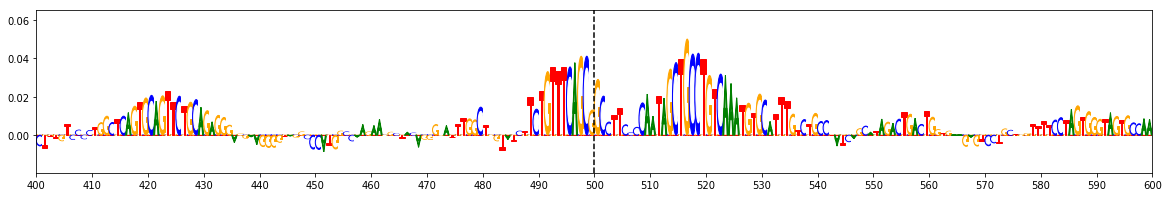

Allele Ratio : 0.8546   ||   Allele Difference : -0.1752  ||  ISM Score : -0.2737  ||  deltaSVM Score : -1.581


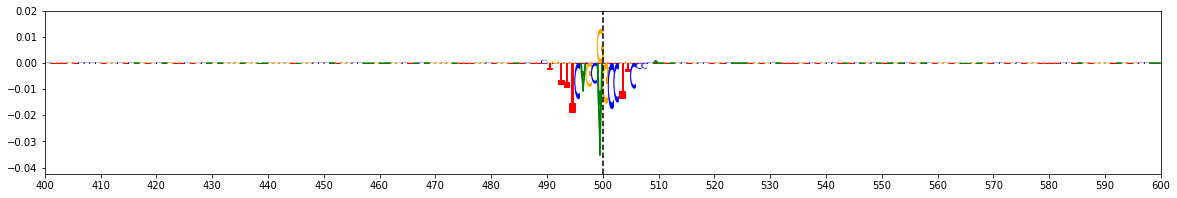


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------




In [6]:
for idx in neg_snps.index[:20]:
    #for idx in [60]:
    print('RSID:', neg_snps.at[idx, 'rsid'],
          '  ||   ', neg_snps.at[idx, 'chr'], ':', neg_snps.at[idx, 'start'], '-', neg_snps.at[idx, 'end'],
          '  ||   ', 'Locus:', idx, '  ||   ', 'IDR Peak:', neg_snps.at[idx, 'idr_peak'])
    
    print()
    
    print('GWAS:')
    
    for i in neg_snps.at[idx, 'all_gwas']:
        entry = i.split(':')
        if 'Lambert' in entry[0] or 'Pankratz' in entry[0] or 'Chang' in entry[0]:
            print(entry[0], '\t', entry[1])
        else:
            print(entry[0], '\t\t', entry[1])
    
    print()
    
    print("Coloc: ", neg_snps.at[idx, 'coloc'])
    
    print()
    
    print('Noneffect Allele :', neg_snps.at[idx, 'noneffect'], '  ||   Explain Score :', round(neg_snps.at[idx, 'noneffect_center'], 4), '  ||   Center / 200bp :', round(neg_snps.at[idx, 'noneffect_ratio'], 4))
    print('Noneffect Sequence :', noneffect_seqs[idx][490:510])
    
    ylim = plot_weights(merged_noneffect_scores[idx], subticks_frequency=10, xlim=(400,600))

    print('Effect Allele :', neg_snps.at[idx, 'effect'], '  ||   Explain Score :', round(neg_snps.at[idx, 'effect_center'], 4), '  ||   Center / 200bp :', round(neg_snps.at[idx, 'effect_ratio'], 4))
    print('Effect Sequence :', effect_seqs[idx][490:510])
    
    a = plot_weights(merged_effect_scores[idx], subticks_frequency=10, ylim=ylim, xlim=(400,600))
    
    print('Allele Ratio :', round(neg_snps.at[idx, 'allele_ratio'], 4), '  ||   Allele Difference :', round(neg_snps.at[idx, 'allele_diff'], 4),
          ' ||  ISM Score :', round(neg_snps.at[idx, 'ism_score'], 4), ' ||  deltaSVM Score :', round(neg_snps.at[idx, 'delta_score'], 4))
    
    a = plot_weights(merged_effect_scores[idx] - merged_noneffect_scores[idx], subticks_frequency=10, xlim=(400,600))
    
    print()
    print('-'*80)
    print('-'*80)
    print()
    print()

## Find Non-Effect Alleles that Improve Accessibility <a name='noneffect_table' />

In [7]:
pos_snps = snps.loc[snps['allele_ratio'] > 1]
pos_snps.sort_values(by=['effect_rank'], ascending=False, inplace=True)
display(pos_snps)

chr      start        end         rsid effect noneffect         ref  \
129  chr19   45039212   45039213   rs34034621      T         C           C   
195   chr8   22599691   22599692     rs755934      T         G           T   
4     chr1  226737182  226737183  rs147889095      I         D  ACTGCCGCTG   
14   chr11   65834088   65834089   rs17854357      C         G           G   
84   chr17   46771150   46771151     rs199523      C         A           C   
19   chr11  121590239  121590240   rs77819448      G         A           A   
6    chr10   15515271   15515272     rs878320      G         C           G   
68   chr17   45942313   45942314   rs62062770      T         C           T   
141   chr2  127097815  127097816   rs34854727      T         C           C   
172   chr4     986675     986676    rs4690220      G         A           A   
113  chr19   44911193   44911194     rs439401      T         C           T   
87   chr17   62065844   62065845    rs3809753      T         C           C   
74   chr17   46057617   46057618   rs62060768      G         A           G   
77   chr17   46131997   46131998  rs111724389      G         A           G   
201   chr9   17578708   17578709    rs3758216      G         C           G   
96   chr18   51198353   51198354    rs3819118      T         C           C   
153   chr2  134719288  134719289   rs62171396      T         C           C   
198   chr8   27608639   27608640    rs1532276      T         C           T   
17   chr11   86069405   86069406    rs3016327      T         C           T   
164   chr3   52288193   52288194  rs146664705      G         C           C   
16   chr11   86068267   86068268    rs2458500      A         G           A   
93   chr17   78432471   78432472    rs7212019      G         A           G   
23   chr14   67515152   67515153    rs2273596      T         C           T   
97   chr19    1040046    1040047    rs3764642      A         G           G   
140   chr2   95264881   95264882    rs4854249      G         A           A   
49   chr17   45775742   45775743   rs55787105      G         A           G   
70   chr17   45949123   45949124   rs77266933      C         A           A   
21   chr12   40224911   40224912  rs139549144      G         C           C   
122  chr19   44954954   44954955  rs117316645      A         G           G   
41   chr17    5282069    5282070  rs113151753      G         C           C   
..     ...        ...        ...          ...    ...       ...         ...   
157   chr3   48685868   48685869    rs6792510      G         C           G   
12   chr11   47408352   47408353    rs7947450      A         G           G   
166   chr3   52339932   52339933  rs149814394      G         A           G   
5    chr10   15515115   15515116     rs878321      G         A           G   
154   chr2  233152670  233152671  rs145770967      A         C           C   
67   chr17   45942276   45942277   rs62062769      G         A           G   
176   chr4   18022407   18022408    rs1380295      G         C           C   
174   chr4     987143     987144   rs10902762      G         A           G   
33   chr16   31142824   31142825    rs1549299      G         A           G   
50   chr17   45775766   45775767   rs62055950      T         C           T   
91   chr17   78421801   78421802    rs2376585      T         C           T   
32   chr16   31074148   31074149    rs2303222      T         C           T   
51   chr17   45818861   45818862   rs12150390      T         C           T   
79   chr17   46132261   46132262   rs17577954      T         C           T   
11   chr11   47395084   47395085   rs55876153      A         G           G   
13   chr11   47426945   47426946   rs11600581      T         C           T   
55   chr17   45849620   45849621    rs8068916      T         G           T   
0     chr1  155135690  155135691   rs12726330      G         A           G   
197   chr8   22623005   22623006   rs11780207      G         A           G   
37   chr17    4902141    4902

## Visualize Top Non-Effect Alleles <a name='noneffect_viz' />

RSID: rs34034621   ||    chr19 : 45039212 - 45039213   ||    Locus: 129   ||    IDR Peak: True

GWAS:
Alzheimers_Jansen_2018 		  4.19E-08

Coloc:  True

Effect Allele: T   ||  Explain Score: 0.5814   ||  Center / 200bp: 0.5622
Effect Sequence: CTGCTGCGTTCCGGCCCCGA


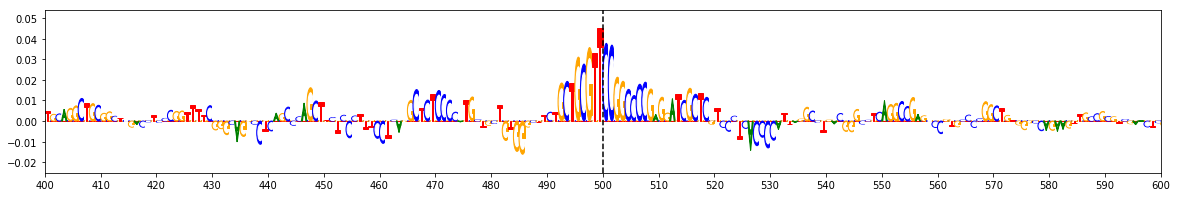

Noneffect Allele: C   ||  Explain Score: 0.3462   ||  Center / 200bp: 0.4337
Noneffect Sequence: CTGCTGCGTCCCGGCCCCGA


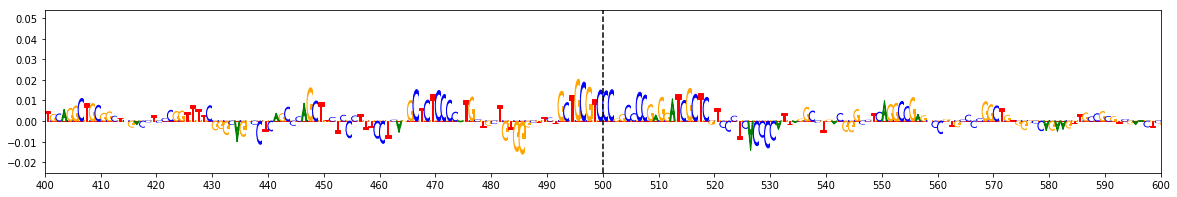

Allele Ratio : 1.6794   ||   Allele Difference : 0.2362  ||  ISM Score : 0.3733  ||  deltaSVM Score : 2.1538


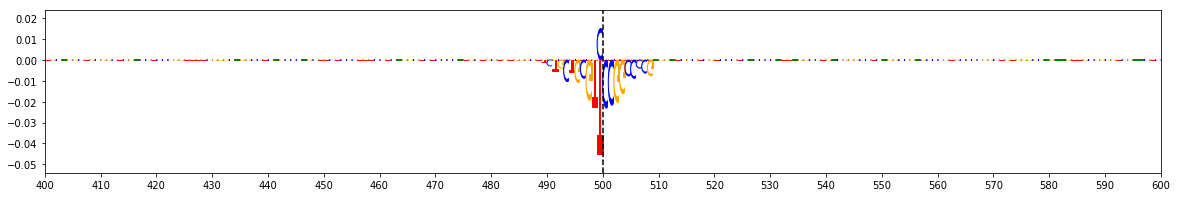


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs755934   ||    chr8 : 22599691 - 22599692   ||    Locus: 195   ||    IDR Peak: True

GWAS:
Chang_23andMe_Parkinsons 	  5.11E-02
Nalls_23andMe 		  5.11E-02

Coloc:  False

Effect Allele: T   ||  Explain Score: 0.7289   ||  Center / 200bp: 0.472
Effect Sequence: GCGGCTGCATTGGCCGGGGC


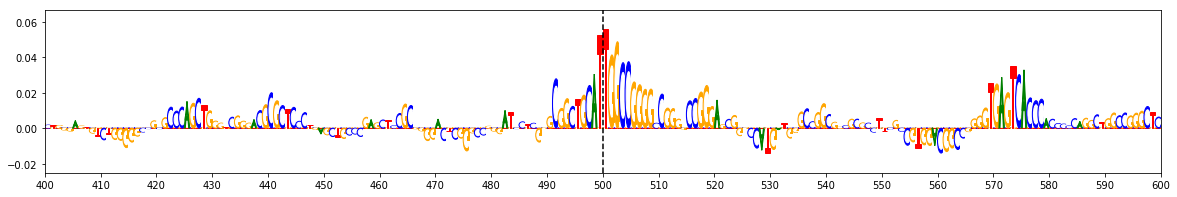

Noneffect Allele: G   ||  Explain Score: 0.3968   ||  Center / 200bp: 0.3287
Noneffect Sequence: GCGGCTGCAGTGGCCGGGGC


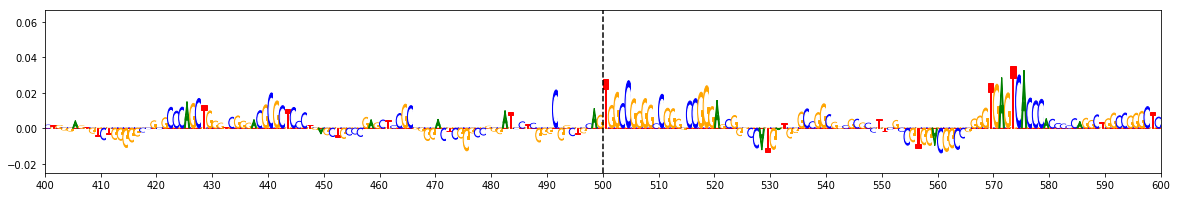

Allele Ratio : 1.8366   ||   Allele Difference : 0.3551  ||  ISM Score : 0.5677  ||  deltaSVM Score : 3.5743


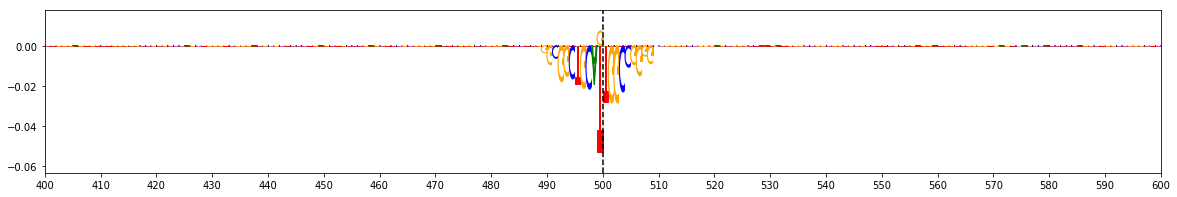


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs147889095   ||    chr1 : 226737182 - 226737183   ||    Locus: 4   ||    IDR Peak: True

GWAS:
Chang_23andMe_Parkinsons 	  1.77E-05
Nalls_23andMe 		  1.77E-05

Coloc:  False

Effect Allele: I   ||  Explain Score: 0.7798   ||  Center / 200bp: 0.5978
Effect Sequence: ACTGCCGCTGCCACTGCCGC


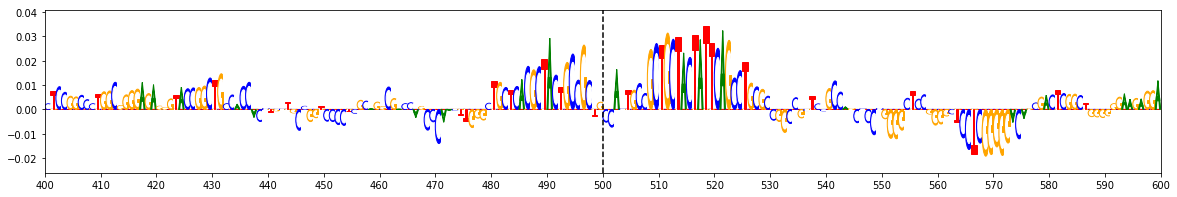

Noneffect Allele: D   ||  Explain Score: 0.5876   ||  Center / 200bp: 0.483
Noneffect Sequence: ACTGCCGCTGCTGCCGCTGC


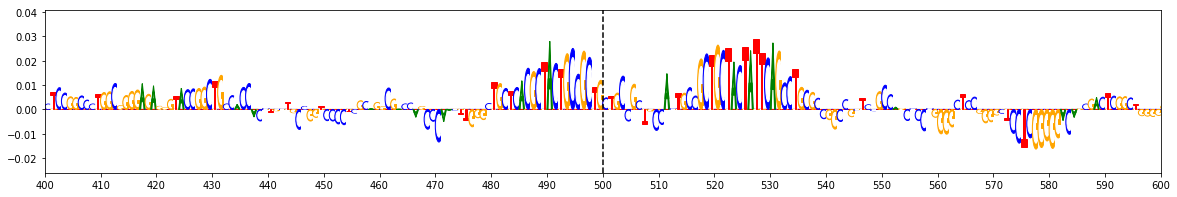

Allele Ratio : 1.327   ||   Allele Difference : 0.2022  ||  ISM Score : 0.2771  ||  deltaSVM Score : 1.5847


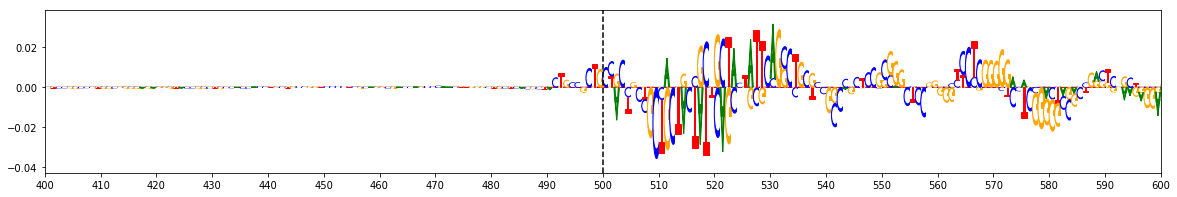


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs17854357   ||    chr11 : 65834088 - 65834089   ||    Locus: 14   ||    IDR Peak: True

GWAS:
Alzheimers_Jansen_2018 		  3.26E-06

Coloc:  True

Effect Allele: C   ||  Explain Score: 0.4013   ||  Center / 200bp: 0.5164
Effect Sequence: GGAGGTTGGCAAGGAGGGCA


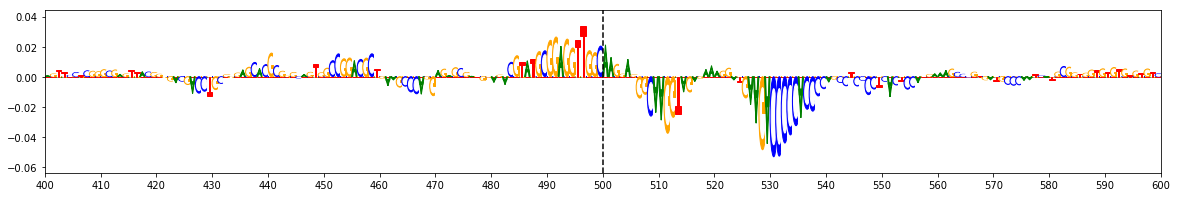

Noneffect Allele: G   ||  Explain Score: 0.2678   ||  Center / 200bp: 0.416
Noneffect Sequence: GGAGGTTGGGAAGGAGGGCA


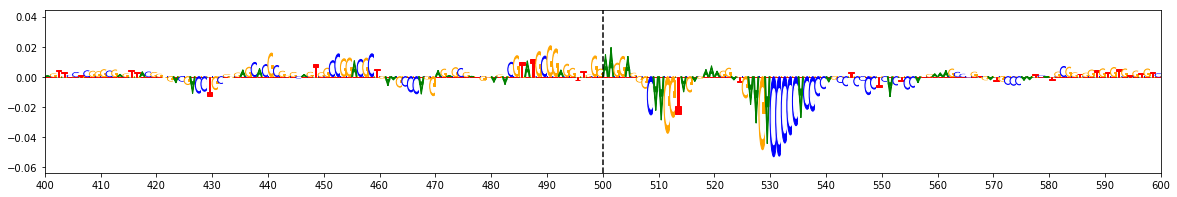

Allele Ratio : 1.4987   ||   Allele Difference : 0.1192  ||  ISM Score : 0.2008  ||  deltaSVM Score : 1.185


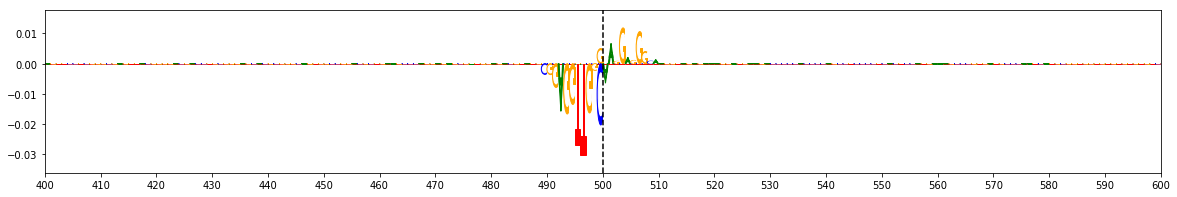


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs199523   ||    chr17 : 46771150 - 46771151   ||    Locus: 84   ||    IDR Peak: False

GWAS:
23andme_PD_hg38 		  9.49E-14

Coloc:  True

Effect Allele: C   ||  Explain Score: 0.9119   ||  Center / 200bp: 0.4214
Effect Sequence: GCCCTCCTGCGCCACCTACA


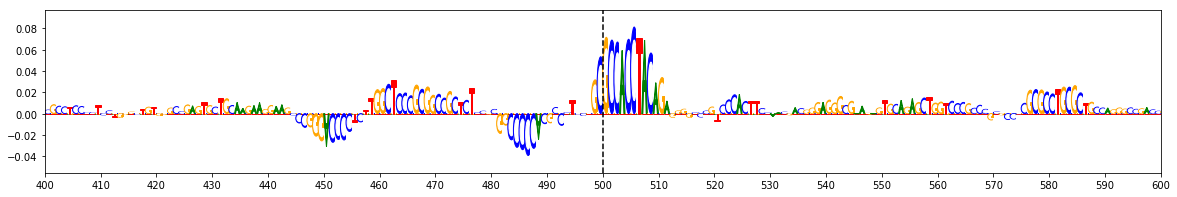

Noneffect Allele: A   ||  Explain Score: 0.5324   ||  Center / 200bp: 0.2979
Noneffect Sequence: GCCCTCCTGAGCCACCTACA


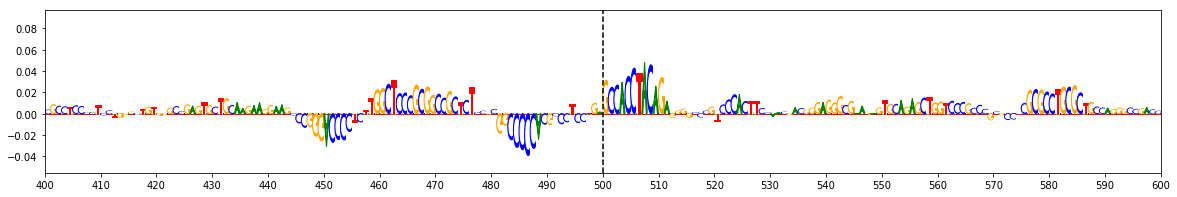

Allele Ratio : 1.7129   ||   Allele Difference : 0.4041  ||  ISM Score : 0.642  ||  deltaSVM Score : 3.7209


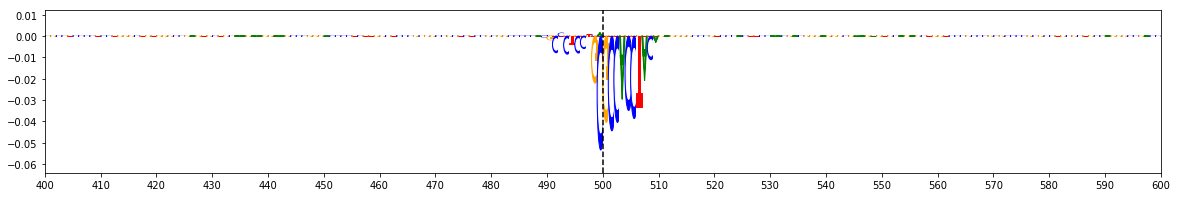


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs77819448   ||    chr11 : 121590239 - 121590240   ||    Locus: 19   ||    IDR Peak: True

GWAS:
Alzheimers_Jansen_2018 		  5.46E-08

Coloc:  False

Effect Allele: G   ||  Explain Score: 1.0878   ||  Center / 200bp: 0.5861
Effect Sequence: CCACCAGCTGTGCAGGATGT


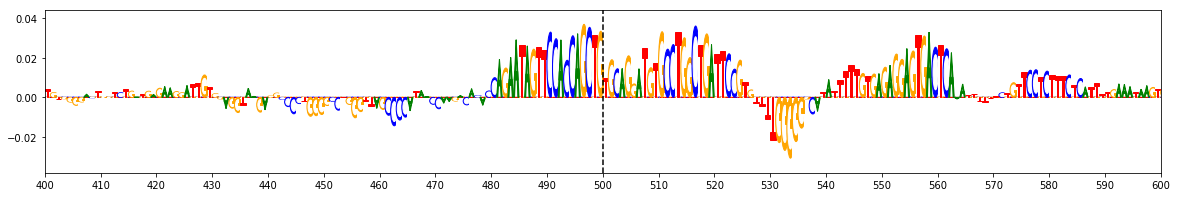

Noneffect Allele: A   ||  Explain Score: 0.8852   ||  Center / 200bp: 0.5354
Noneffect Sequence: CCACCAGCTATGCAGGATGT


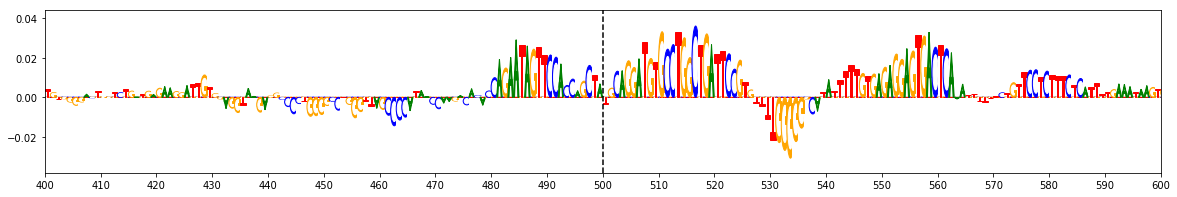

Allele Ratio : 1.2288   ||   Allele Difference : 0.2061  ||  ISM Score : 0.3226  ||  deltaSVM Score : 1.8724


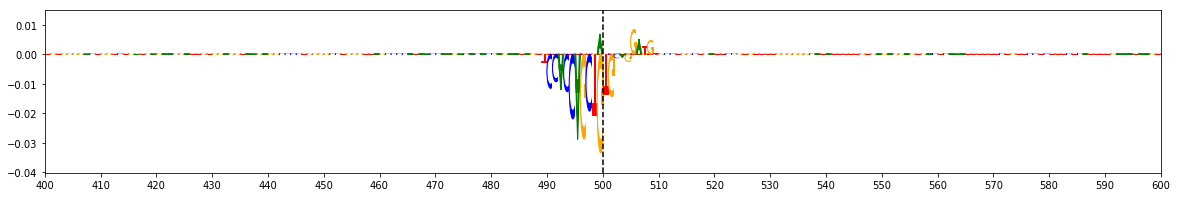


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs878320   ||    chr10 : 15515271 - 15515272   ||    Locus: 6   ||    IDR Peak: True

GWAS:
Chang_23andMe_Parkinsons 	  4.88E-04
Nalls_23andMe 		  4.88E-04

Coloc:  False

Effect Allele: G   ||  Explain Score: 0.8186   ||  Center / 200bp: 0.5066
Effect Sequence: AACTTCAGTGCTCATCCGTA


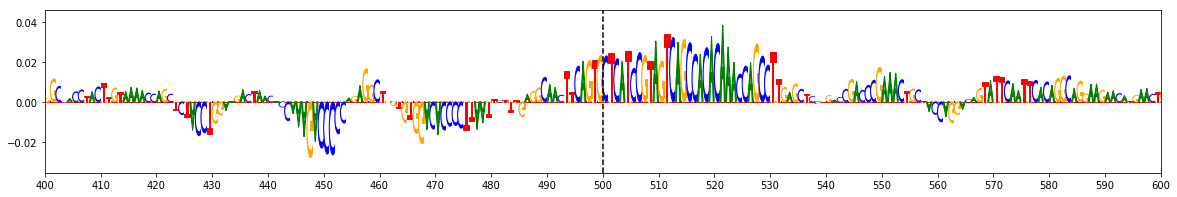

Noneffect Allele: C   ||  Explain Score: 0.595   ||  Center / 200bp: 0.4272
Noneffect Sequence: AACTTCAGTCCTCATCCGTA


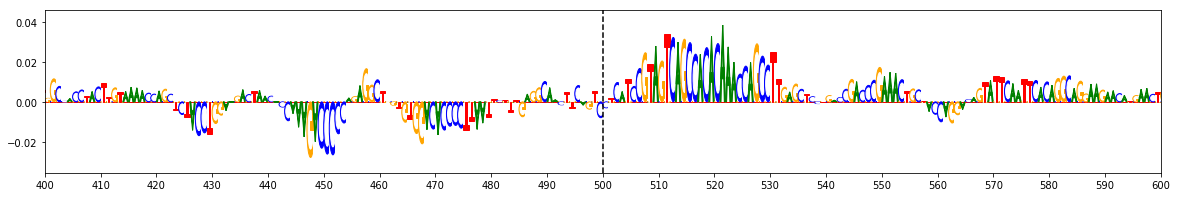

Allele Ratio : 1.3757   ||   Allele Difference : 0.2442  ||  ISM Score : 0.3815  ||  deltaSVM Score : 2.1792


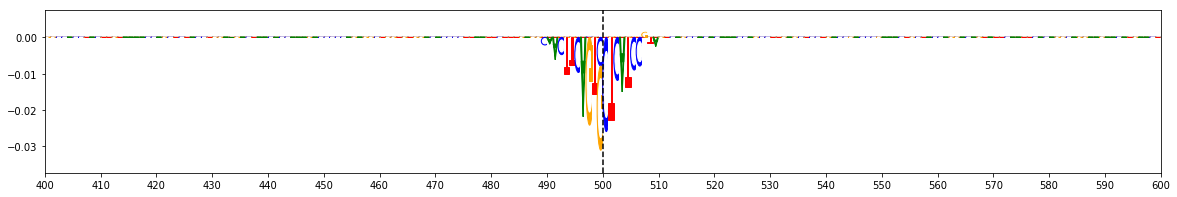


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs62062770   ||    chr17 : 45942313 - 45942314   ||    Locus: 68   ||    IDR Peak: True

GWAS:
23andme_PD_hg38 		  3.67E-22

Coloc:  True

Effect Allele: T   ||  Explain Score: 1.0549   ||  Center / 200bp: 0.6181
Effect Sequence: CGTTTCTTCTTCCTTACAAA


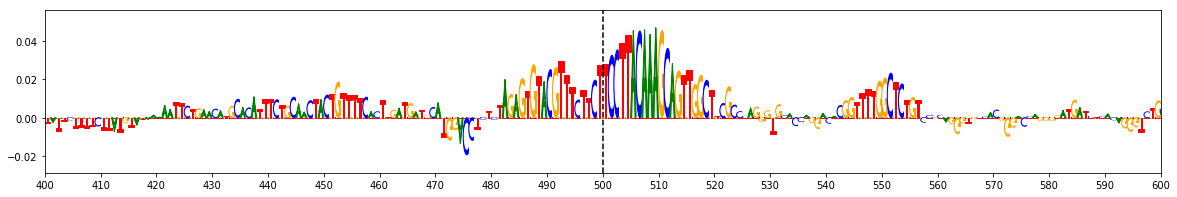

Noneffect Allele: C   ||  Explain Score: 0.9382   ||  Center / 200bp: 0.5901
Noneffect Sequence: CGTTTCTTCCTCCTTACAAA


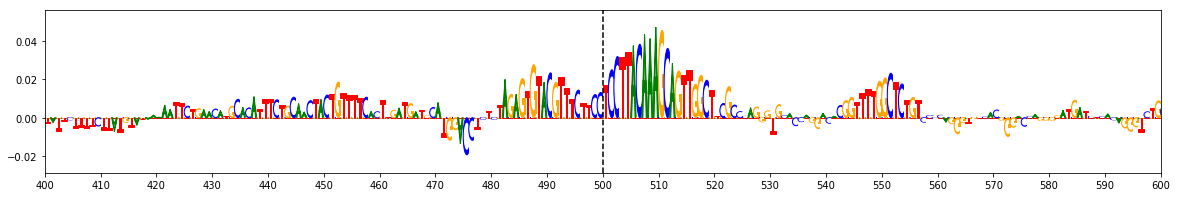

Allele Ratio : 1.1243   ||   Allele Difference : 0.1167  ||  ISM Score : 0.1818  ||  deltaSVM Score : 1.0593


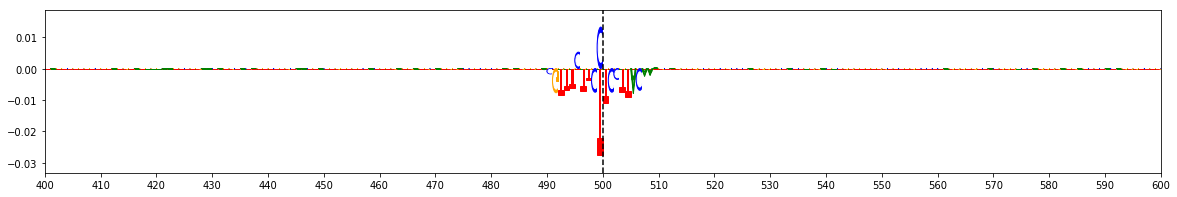


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs34854727   ||    chr2 : 127097815 - 127097816   ||    Locus: 141   ||    IDR Peak: True

GWAS:
Alzheimers_Lambert_2013 	  6.75E-08
Alzheimers_Kunkle_2019 		  1.99E-10

Coloc:  False

Effect Allele: T   ||  Explain Score: 0.5279   ||  Center / 200bp: 0.3139
Effect Sequence: AGCCCAGGCTCAGCCTCTGC


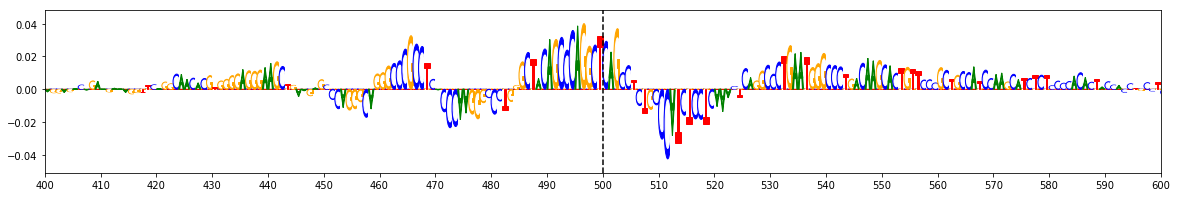

Noneffect Allele: C   ||  Explain Score: 0.2423   ||  Center / 200bp: 0.1741
Noneffect Sequence: AGCCCAGGCCCAGCCTCTGC


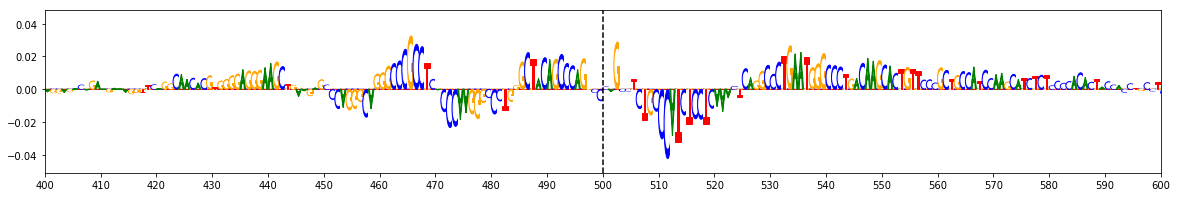

Allele Ratio : 2.1785   ||   Allele Difference : 0.31  ||  ISM Score : 0.4918  ||  deltaSVM Score : 2.817


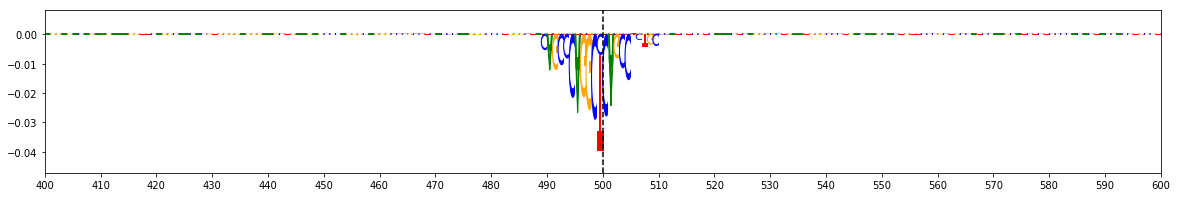


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs4690220   ||    chr4 : 986675 - 986676   ||    Locus: 172   ||    IDR Peak: True

GWAS:
23andme_PD_hg38 		  8.23E-10

Coloc:  True

Effect Allele: G   ||  Explain Score: 0.6873   ||  Center / 200bp: 0.4804
Effect Sequence: AAATCGCTGGAGCCCCGGAG


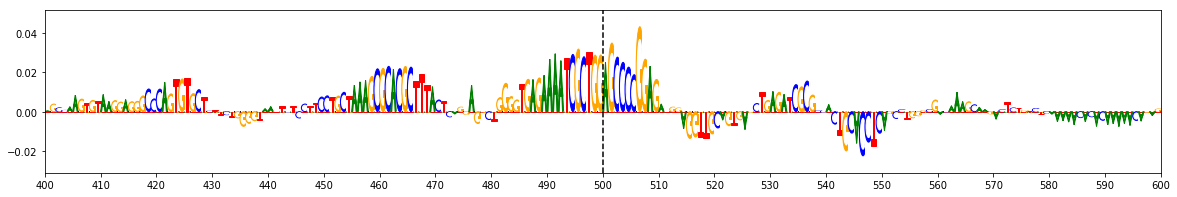

Noneffect Allele: A   ||  Explain Score: 0.4859   ||  Center / 200bp: 0.3953
Noneffect Sequence: AAATCGCTGAAGCCCCGGAG


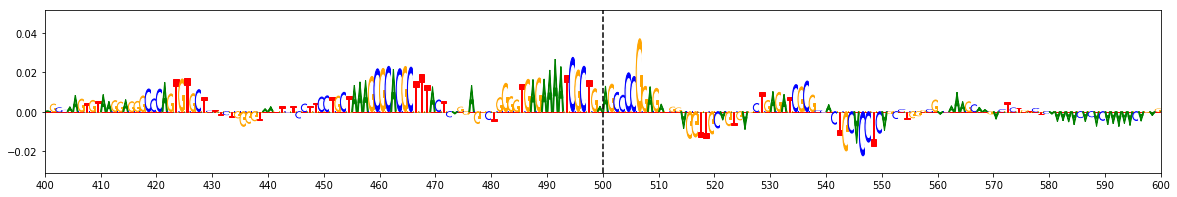

Allele Ratio : 1.4143   ||   Allele Difference : 0.2013  ||  ISM Score : 0.315  ||  deltaSVM Score : 1.8326


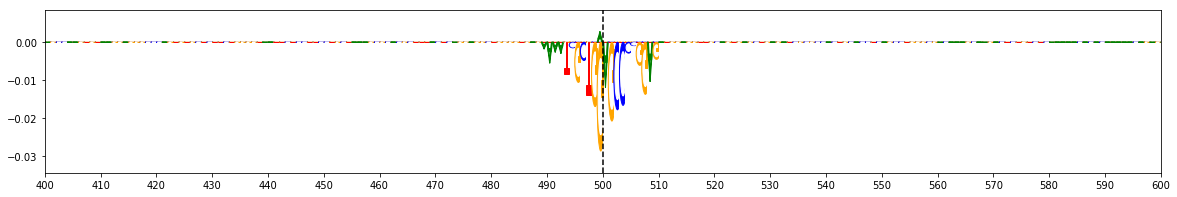


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs439401   ||    chr19 : 44911193 - 44911194   ||    Locus: 113   ||    IDR Peak: True

GWAS:
Alzheimers_Jansen_2018 		  1.76E-165
Alzheimers_Kunkle_2019 		  7.61E-128
Alzheimers_Lambert_2013 	  3.54E-79

Coloc:  True

Effect Allele: T   ||  Explain Score: 1.268   ||  Center / 200bp: 0.5658
Effect Sequence: ACTCTCTTCTCCTCCCACCC


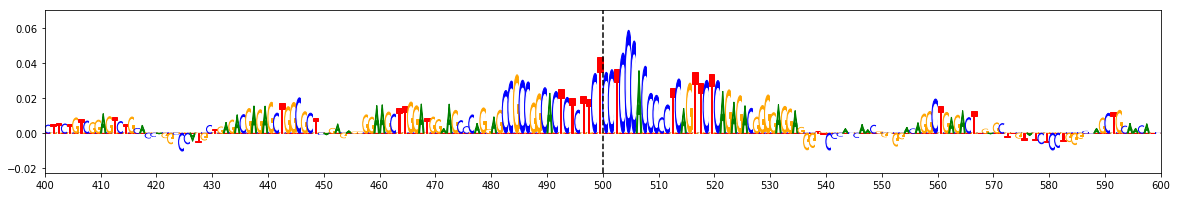

Noneffect Allele: C   ||  Explain Score: 1.0724   ||  Center / 200bp: 0.525
Noneffect Sequence: ACTCTCTTCCCCTCCCACCC


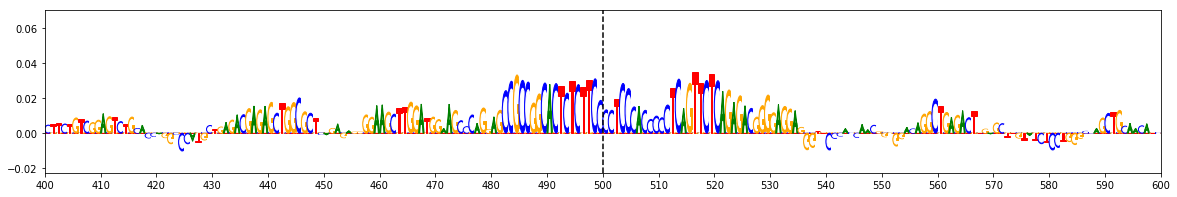

Allele Ratio : 1.1823   ||   Allele Difference : 0.1955  ||  ISM Score : 0.3041  ||  deltaSVM Score : 1.7695


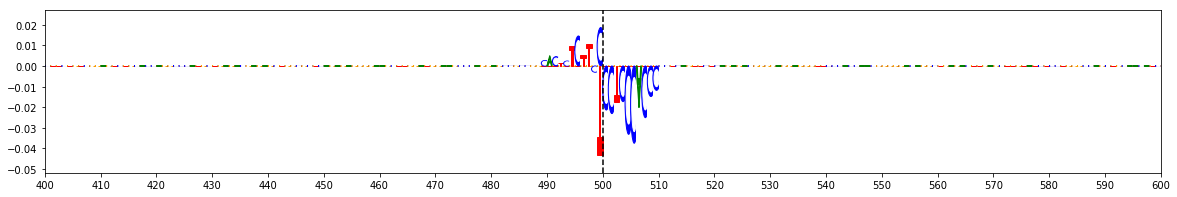


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs3809753   ||    chr17 : 62065844 - 62065845   ||    Locus: 87   ||    IDR Peak: True

GWAS:
Nalls_23andMe 		  1.70E-04

Coloc:  False

Effect Allele: T   ||  Explain Score: 0.9733   ||  Center / 200bp: 0.4813
Effect Sequence: TGGCCTCACTGGCTGGACGC


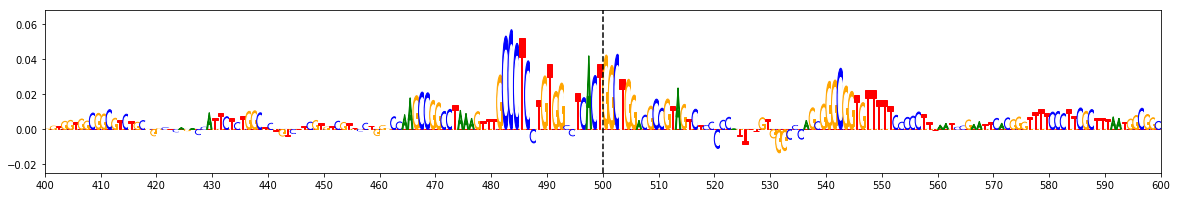

Noneffect Allele: C   ||  Explain Score: 0.7006   ||  Center / 200bp: 0.4008
Noneffect Sequence: TGGCCTCACCGGCTGGACGC


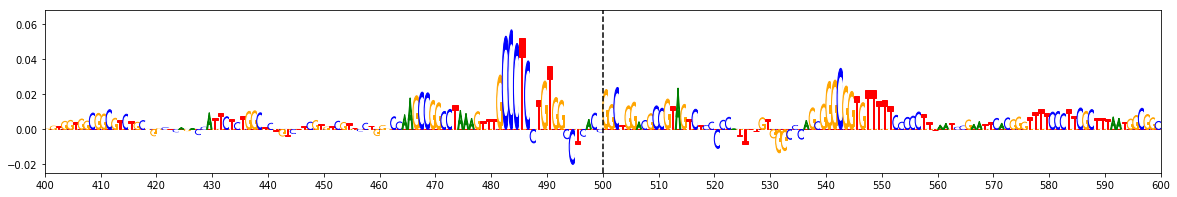

Allele Ratio : 1.3893   ||   Allele Difference : 0.3077  ||  ISM Score : 0.482  ||  deltaSVM Score : 2.7607


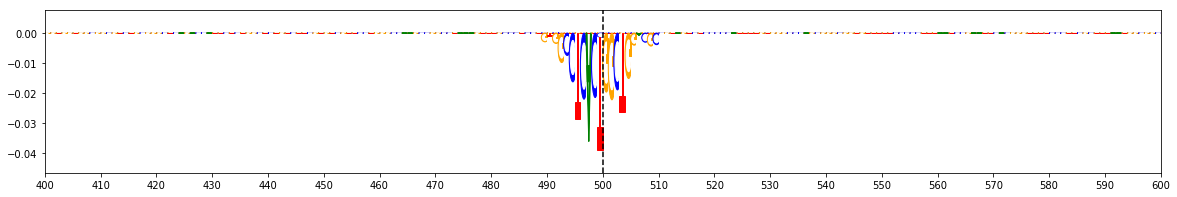


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs62060768   ||    chr17 : 46057617 - 46057618   ||    Locus: 74   ||    IDR Peak: True

GWAS:
23andme_PD_hg38 		  2.51E-22

Coloc:  True

Effect Allele: G   ||  Explain Score: 1.196   ||  Center / 200bp: 0.5912
Effect Sequence: TTTTCTCACGAAACTAAAAC


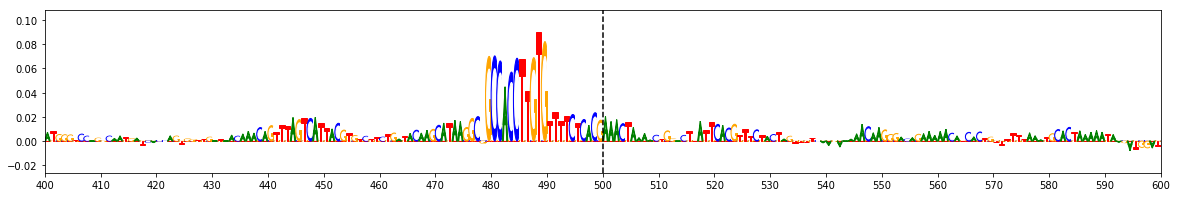

Noneffect Allele: A   ||  Explain Score: 1.0841   ||  Center / 200bp: 0.5674
Noneffect Sequence: TTTTCTCACAAAACTAAAAC


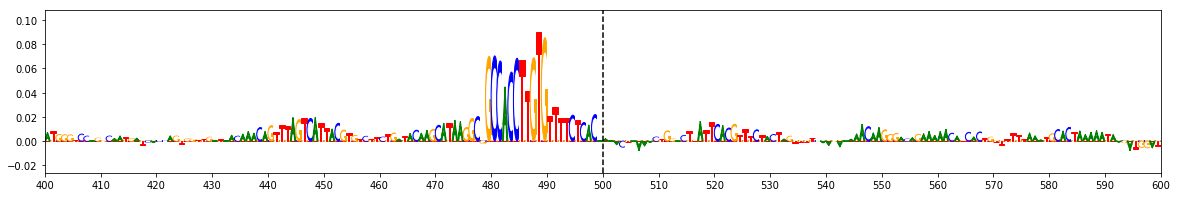

Allele Ratio : 1.1032   ||   Allele Difference : 0.134  ||  ISM Score : 0.2119  ||  deltaSVM Score : 1.1769


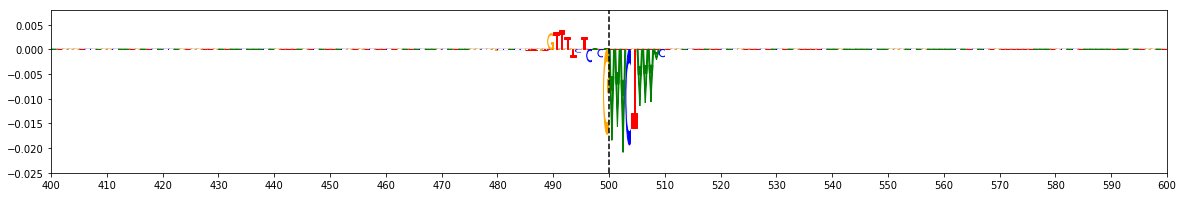


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs111724389   ||    chr17 : 46131997 - 46131998   ||    Locus: 77   ||    IDR Peak: False

GWAS:
23andme_PD_hg38 		  2.70E-22

Coloc:  True

Effect Allele: G   ||  Explain Score: 0.3954   ||  Center / 200bp: 0.6402
Effect Sequence: TGACGGCGCGTGCCTGTAAT


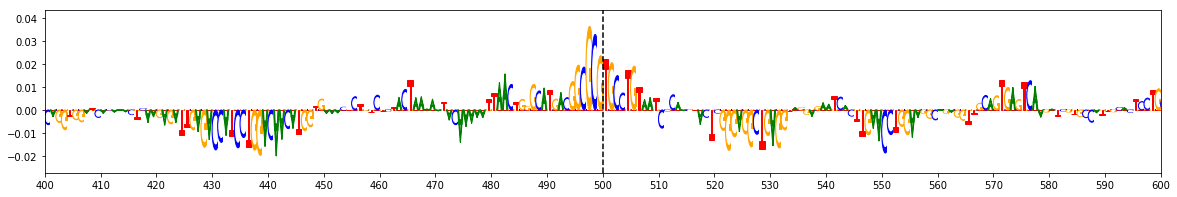

Noneffect Allele: A   ||  Explain Score: 0.3889   ||  Center / 200bp: 0.6377
Noneffect Sequence: TGACGGCGCATGCCTGTAAT


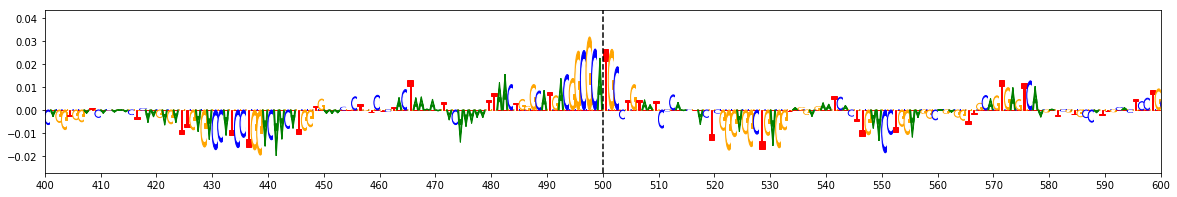

Allele Ratio : 1.0168   ||   Allele Difference : 0.0098  ||  ISM Score : 0.0134  ||  deltaSVM Score : 0.0447


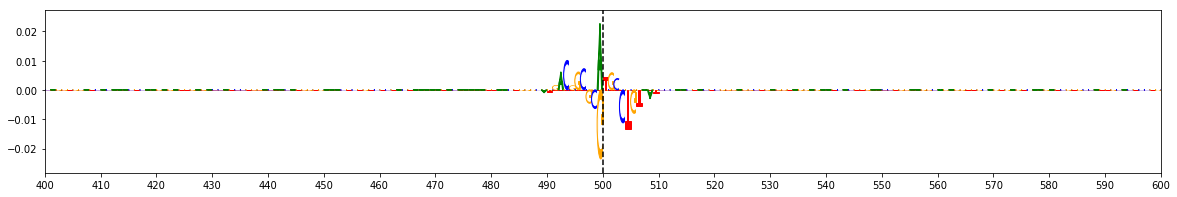


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs3758216   ||    chr9 : 17578708 - 17578709   ||    Locus: 201   ||    IDR Peak: True

GWAS:
Chang_23andMe_Parkinsons 	  1.23E-04
Nalls_23andMe 		  1.23E-04

Coloc:  False

Effect Allele: G   ||  Explain Score: 1.0919   ||  Center / 200bp: 0.523
Effect Sequence: AGAAGGCCAGTCTTTTTCAG


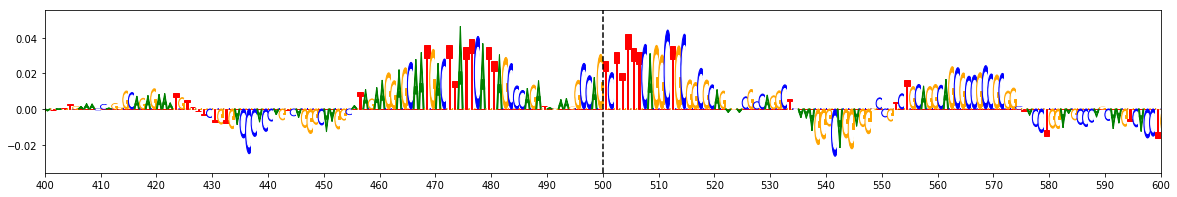

Noneffect Allele: C   ||  Explain Score: 0.8908   ||  Center / 200bp: 0.4719
Noneffect Sequence: AGAAGGCCACTCTTTTTCAG


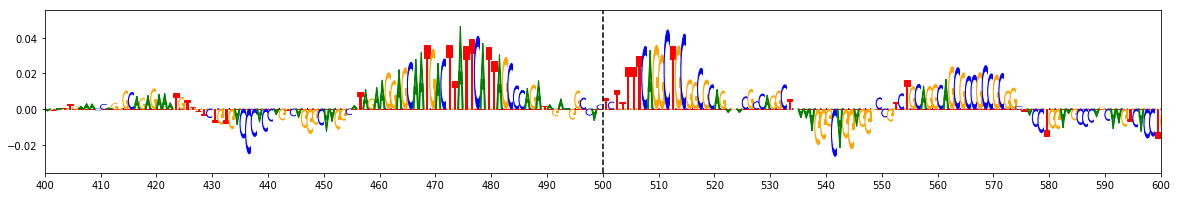

Allele Ratio : 1.2257   ||   Allele Difference : 0.2206  ||  ISM Score : 0.3459  ||  deltaSVM Score : 1.966


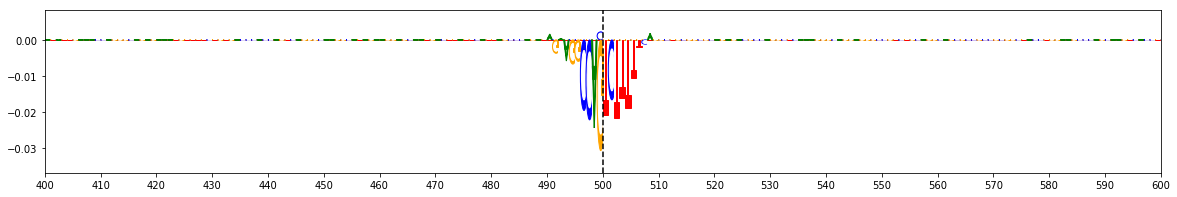


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs3819118   ||    chr18 : 51198353 - 51198354   ||    Locus: 96   ||    IDR Peak: True

GWAS:
Nalls_23andMe 		  3.41E-04

Coloc:  False

Effect Allele: T   ||  Explain Score: 1.186   ||  Center / 200bp: 0.5571
Effect Sequence: CCGCTGGCCTGGCTTCTCTG


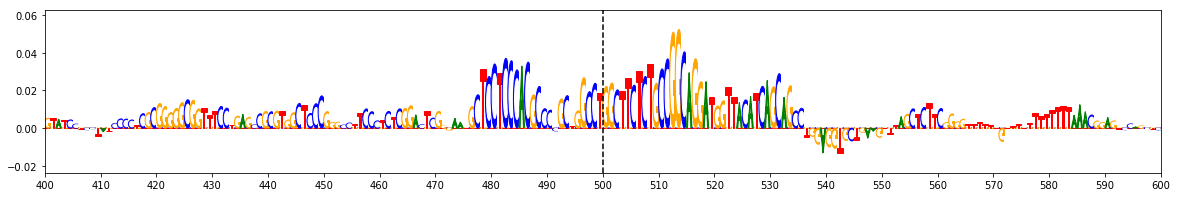

Noneffect Allele: C   ||  Explain Score: 1.0469   ||  Center / 200bp: 0.5261
Noneffect Sequence: CCGCTGGCCCGGCTTCTCTG


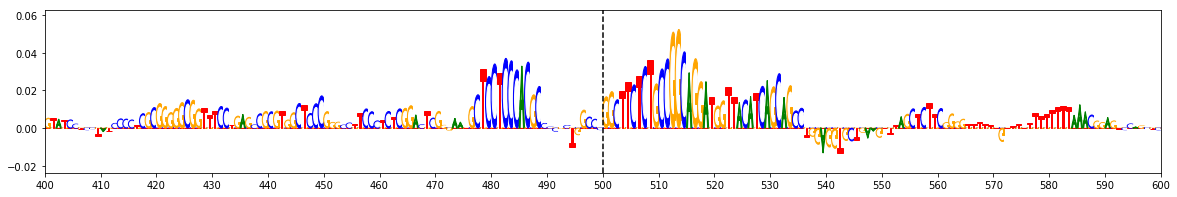

Allele Ratio : 1.1329   ||   Allele Difference : 0.1538  ||  ISM Score : 0.2444  ||  deltaSVM Score : 1.4368


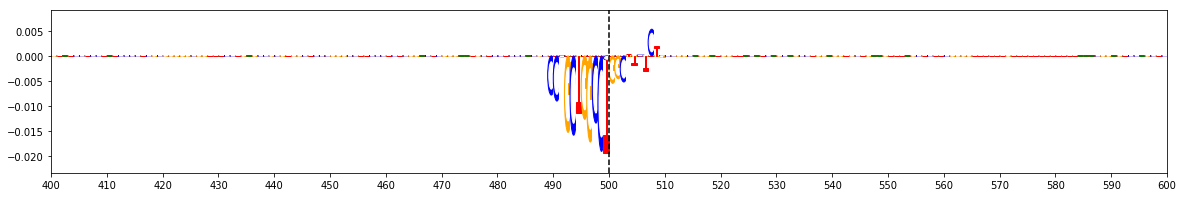


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs62171396   ||    chr2 : 134719288 - 134719289   ||    Locus: 153   ||    IDR Peak: True

GWAS:
Nalls_23andMe 		  1.04E-02

Coloc:  False

Effect Allele: T   ||  Explain Score: 0.7754   ||  Center / 200bp: 0.4398
Effect Sequence: ACAGGCGGCTCTGGCAGAGC


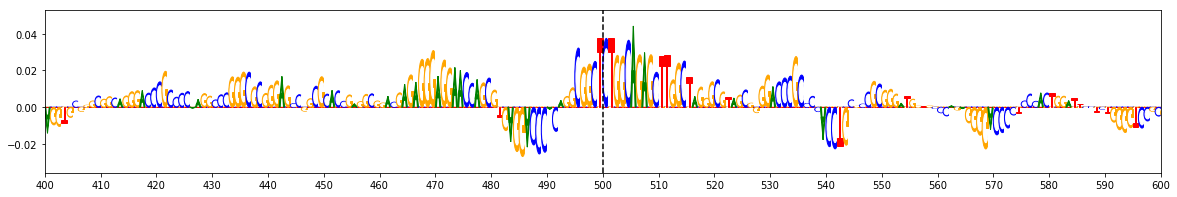

Noneffect Allele: C   ||  Explain Score: 0.5406   ||  Center / 200bp: 0.3526
Noneffect Sequence: ACAGGCGGCCCTGGCAGAGC


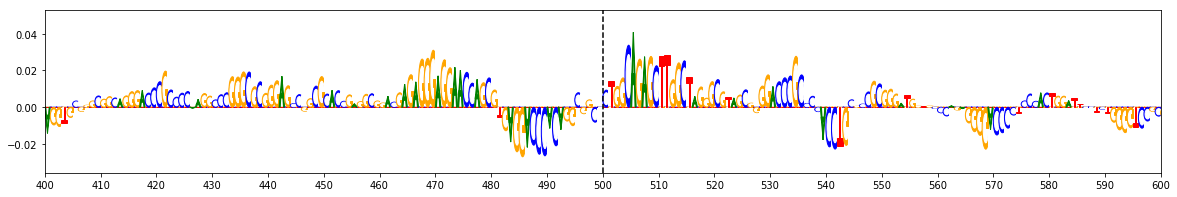

Allele Ratio : 1.4343   ||   Allele Difference : 0.2969  ||  ISM Score : 0.4727  ||  deltaSVM Score : 2.7497


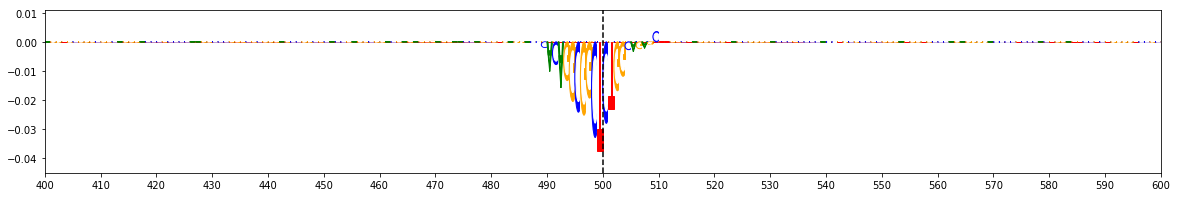


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs1532276   ||    chr8 : 27608639 - 27608640   ||    Locus: 198   ||    IDR Peak: True

GWAS:
Alzheimers_Jansen_2018 		  4.00E-19
Alzheimers_Kunkle_2019 		  1.73E-16
Alzheimers_Lambert_2013 	  5.72E-17

Coloc:  True

Effect Allele: T   ||  Explain Score: 0.5051   ||  Center / 200bp: 0.4568
Effect Sequence: GCCACCCCATCCAGAGCCTG


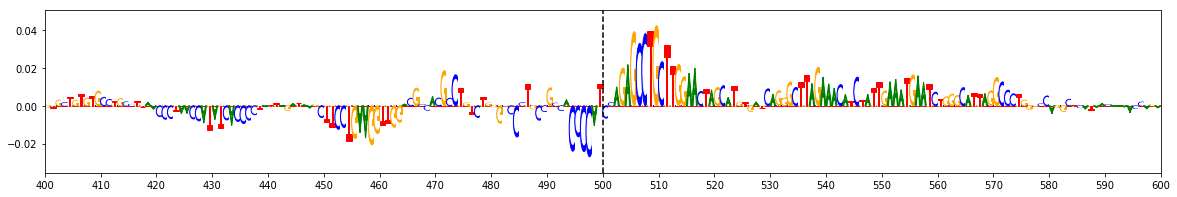

Noneffect Allele: C   ||  Explain Score: 0.3757   ||  Center / 200bp: 0.385
Noneffect Sequence: GCCACCCCACCCAGAGCCTG


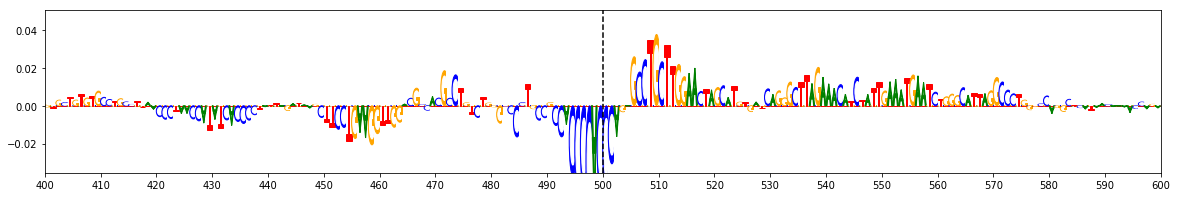

Allele Ratio : 1.3445   ||   Allele Difference : 0.4391  ||  ISM Score : 0.6846  ||  deltaSVM Score : 3.9549


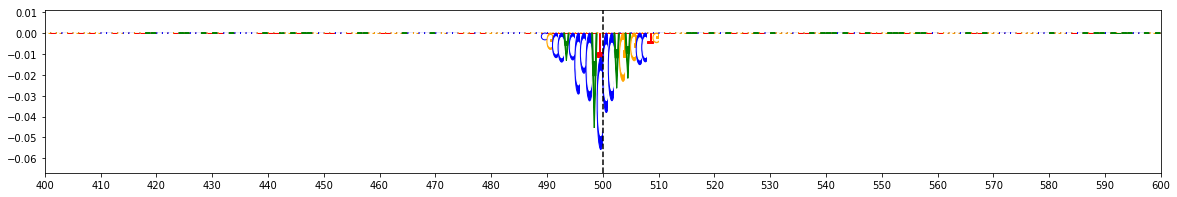


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs3016327   ||    chr11 : 86069405 - 86069406   ||    Locus: 17   ||    IDR Peak: True

GWAS:
Alzheimers_Jansen_2018 		  1.41E-11

Coloc:  False

Effect Allele: T   ||  Explain Score: 1.0769   ||  Center / 200bp: 0.5208
Effect Sequence: CGAGGGCGGTGTGCTGGCGG


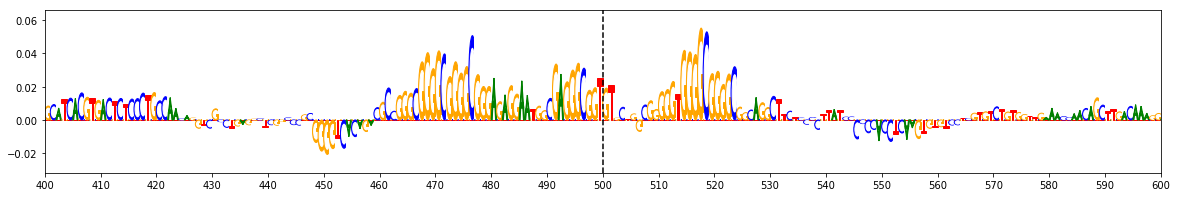

Noneffect Allele: C   ||  Explain Score: 0.9178   ||  Center / 200bp: 0.4812
Noneffect Sequence: CGAGGGCGGCGTGCTGGCGG


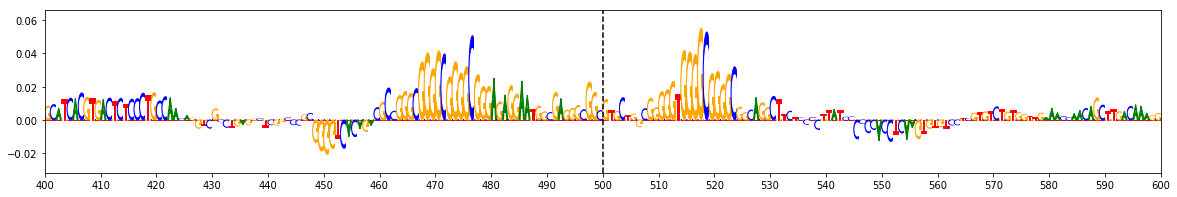

Allele Ratio : 1.1734   ||   Allele Difference : 0.1564  ||  ISM Score : 0.259  ||  deltaSVM Score : 1.5627


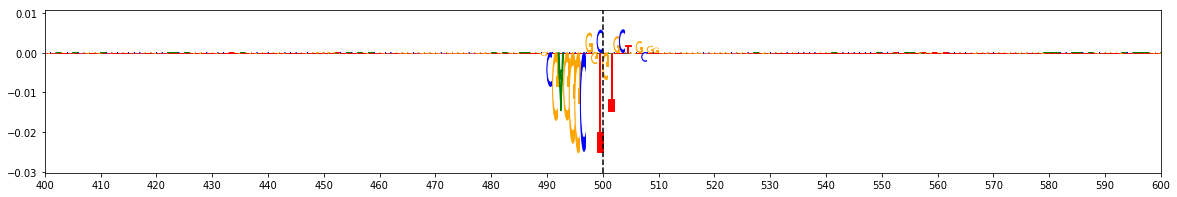


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs146664705   ||    chr3 : 52288193 - 52288194   ||    Locus: 164   ||    IDR Peak: True

GWAS:
Chang_23andMe_Parkinsons 	  1.04E-03

Coloc:  False

Effect Allele: G   ||  Explain Score: 0.747   ||  Center / 200bp: 0.5309
Effect Sequence: AGGACTTAGGAAATAAAAAT


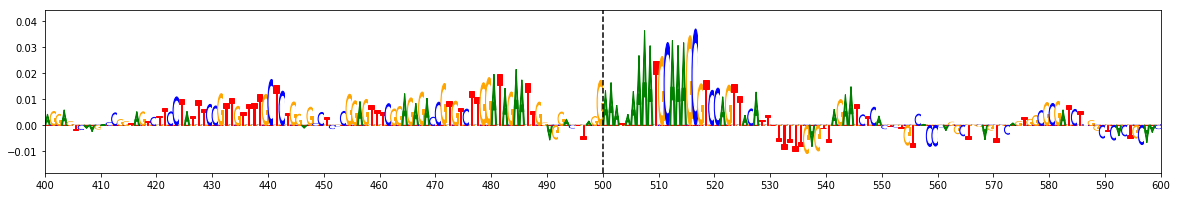

Noneffect Allele: C   ||  Explain Score: 0.6535   ||  Center / 200bp: 0.4975
Noneffect Sequence: AGGACTTAGCAAATAAAAAT


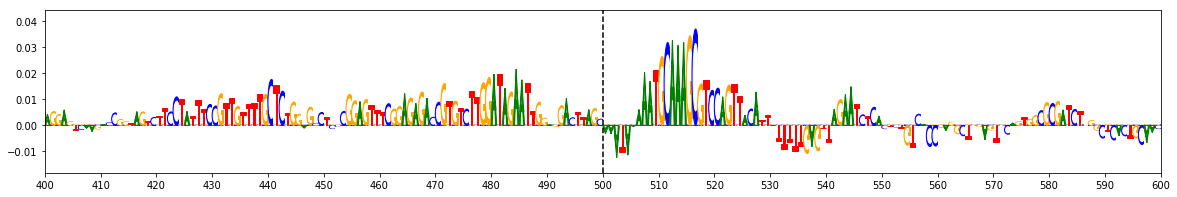

Allele Ratio : 1.143   ||   Allele Difference : 0.1175  ||  ISM Score : 0.1839  ||  deltaSVM Score : 1.0596


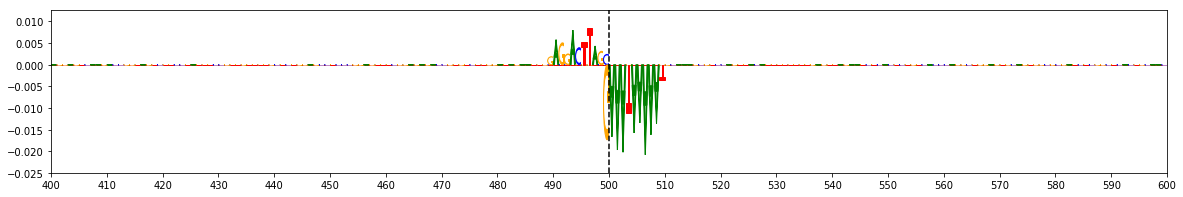


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------




In [8]:
for idx in pos_snps.index[:20]:
    #for idx in [60]:
    print('RSID:', pos_snps.at[idx, 'rsid'],
          '  ||   ', pos_snps.at[idx, 'chr'], ':', pos_snps.at[idx, 'start'], '-', pos_snps.at[idx, 'end'],
          '  ||   ', 'Locus:', idx, '  ||   ', 'IDR Peak:', pos_snps.at[idx, 'idr_peak'])
    
    print()
    
    print('GWAS:')
    
    for i in pos_snps.at[idx, 'all_gwas']:
        entry = i.split(':')
        if 'Lambert' in entry[0] or 'Pankratz' in entry[0] or 'Chang' in entry[0]:
            print(entry[0], '\t', entry[1])
        else:
            print(entry[0], '\t\t', entry[1])
    
    print()
        
    print("Coloc: ", pos_snps.at[idx, 'coloc'])
    
    print()
    
    print('Effect Allele:', pos_snps.at[idx, 'effect'], '  ||  Explain Score:', round(pos_snps.at[idx, 'effect_center'], 4), '  ||  Center / 200bp:', round(pos_snps.at[idx, 'effect_ratio'], 4))
    print('Effect Sequence:', effect_seqs[idx][490:510])
    
    ylim = plot_weights(merged_effect_scores[idx], subticks_frequency=10, xlim=(400,600))

    print('Noneffect Allele:', pos_snps.at[idx, 'noneffect'], '  ||  Explain Score:', round(pos_snps.at[idx, 'noneffect_center'], 4), '  ||  Center / 200bp:', round(pos_snps.at[idx, 'noneffect_ratio'], 4))
    print('Noneffect Sequence:', noneffect_seqs[idx][490:510])
    
    a = plot_weights(merged_noneffect_scores[idx], subticks_frequency=10, ylim=ylim, xlim=(400,600))
    
    print('Allele Ratio :', round(pos_snps.at[idx, 'allele_ratio'], 4), '  ||   Allele Difference :', round(pos_snps.at[idx, 'allele_diff'], 4),
          ' ||  ISM Score :', round(pos_snps.at[idx, 'ism_score'], 4), ' ||  deltaSVM Score :', round(pos_snps.at[idx, 'delta_score'], 4))
    
    a = plot_weights(merged_noneffect_scores[idx] - merged_effect_scores[idx], subticks_frequency=10, xlim=(400,600))
    
    print()
    print('-'*80)
    print('-'*80)
    print()
    print()